Using XGBoost to predict individuals' ethnic breakdown using G25 coordinates of both modern and ancient DNA samples

In [1]:
require(rio)
require(tidyverse)
require(xgboost)
require(ggrepel)
require(cowplot)

Loading required package: xgboost


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loading required package: ggrepel

Loading required package: cowplot


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [358]:
bad = as_tibble(import("../Genetics/G25/Data/CSV/Eurasia/G25_BA.csv"))
iad = as_tibble(import("../Genetics/G25/Data/CSV/Eurasia/G25_IA.csv"))
mad = as_tibble(import("../Genetics/G25/Data/CSV/Eurasia/G25_MA.csv"))
mod = as_tibble(import("../Genetics/G25/Data/CSV/Eurasia/Global25_PCA_modern_scaled.txt"))

In [285]:
head(bad,1)
head(iad,1)
head(mad,1)
head(mod,1)

sample                 V2       V3       V4        V5       V6      
1 Aidonia_LBA.rel:AID002 0.126344 0.158423 -0.001131 -0.05814 0.026159
  V7        V8       V9        V10      ⋯ V17       V18      V19       V20     
1 -0.025937 -0.00188 -0.001154 0.002454 ⋯ -0.006364 0.008345 -0.001774 0.002514
  V21       V22       V23       V24      V25       V26     
1 -0.005002 -0.006114 -0.004575 0.000986 -0.001566 -0.00455

sample               V2       V3       V4      V5        V6       V7       
1 Albania_BA_IA:I14688 0.119514 0.160454 0.02225 -0.028101 0.024312 -0.017012
  V8      V9        V10       ⋯ V17       V18       V19      V20      V21      
1 0.00141 -0.001385 -0.001841 ⋯ -0.016176 -0.008736 0.003674 0.003645 -0.004502
  V22       V23      V24       V25      V26      
1 -0.013726 0.009645 -0.001849 0.011809 -0.011855

sample                  V2       V3       V4       V5        V6     
1 Albania_Medieval:I13839 0.125205 0.153345 0.016216 -0.036176 0.03139
  V7        V8 V9       V10      ⋯ V17      V18      V19      V20     
1 -0.013108 0  0.002077 0.007772 ⋯ -0.01074 0.008996 0.004307 0.006536
  V21       V22       V23      V24      V25       V26     
1 -0.016508 -0.007237 0.001113 0.005053 -0.001205 0.001676

sample           PC1     PC2      PC3       PC4       PC5       PC6     
1 Abazin:KCHE-1032 0.10927 0.072103 -0.023004 -0.016796 -0.028005 0.003347
  PC7      PC8       PC9       ⋯ PC16     PC17      PC18      PC19     
1 0.003055 -0.010384 -0.049904 ⋯ -0.01074 -0.001173 -0.004054 -0.006662
  PC20     PC21     PC22      PC23      PC24      PC25     
1 0.023386 0.004742 -0.000124 -0.000863 -0.010965 -0.001916

In [359]:
colnames(mod) = colnames(bad)
myptrna = "^.+(?=:)"
myptrnb = "^\\w+?_\\w+?(?=[_:\\.])"
mod = mod %>% mutate(sample = str_extract(sample,myptrna))
bad = bad %>% mutate(sample = str_extract(sample,myptrnb))
iad = iad %>% mutate(sample = str_extract(sample,myptrnb))
mad = mad %>% mutate(sample = str_extract(sample,myptrnb))

In [155]:
mod %>% count(sample,sort = TRUE) %>% head(20)

sample           n  
1  Dutch            166
2  Swedish          101
3  Greek_Crete      100
4  Irish             85
5  Danish            81
6  German            79
7  German_Erlangen   67
8  Lak               52
9  Moldovan          42
10 Polish            41
11 French_Alsace     40
12 French_Brittany   40
13 Norwegian         40
14 Mongol_IMAR       39
15 French_Occitanie  36
16 French_Nord       33
17 Karelian          33
18 Tunisian_Douz     33
19 Bashkir           31
20 Greek_Laconia     31

In [78]:
bad %>% count(sample,sort = TRUE) %>% head(10)

sample             n  
1  Czech_EBA          100
2  Poland_Trzciniec    66
3  Czech_CordedWare    41
4  Czech_BellBeaker    34
5  Armenia_LBA         30
6  England_BellBeaker  27
7  Serbia_Mokrin       27
8  Israel_MLBA         26
9  Sweden_Gotland      26
10 Turkey_EBA          26

In [79]:
iad %>% count(sample,sort = TRUE) %>% head(10)

sample                n  
1  England_MIA           122
2  Armenia_LBA            42
3  England_EIA            32
4  England_EastYorkshire  30
5  Mongolia_EIA           25
6  Czech_IA               23
7  Poland_Kowalewko       23
8  Kazakhstan_Tasmola     19
9  Iran_Hasanlu           18
10 Italy_Tuscany          18

In [80]:
mad %>% count(sample,sort = TRUE) %>% head(10)

sample                n  
1  Sweden_Viking         118
2  England_EarlyMedieval  89
3  Denmark_Viking         68
4  Italy_Medieval         38
5  Estonia_EarlyViking    34
6  Ireland_Kilteasheen    30
7  England_Viking         29
8  Vladimir_MA            28
9  Mongolia_Arkhangai     26
10 Norway_Viking          26

In [28]:
ppl = as_tibble(import("../Genetics/G25/Data/People/All.txt"))

In [17]:
ppl

V1        V2       V3       V4        V5        V6       V7        V8       
1 RN:RN2020 0.100164 0.135065 -0.003771 -0.041667 0.009540 -0.017570 -0.004465
2 TP:TP2022 0.127482 0.125926  0.072407  0.060724 0.033852  0.024821  0.010340
3 MN:MN2020 0.097888 0.141159 -0.002640 -0.051034 0.009540 -0.017012 -0.007285
4 MD:MD2022 0.099026 0.129988 -0.001886 -0.041667 0.011079 -0.015060  0.002350
  V9        V10       ⋯ V17       V18       V19       V20       V21      
1 -0.003000  0.008590 ⋯ -0.013657 -0.016168  0.003801  0.001508 -0.005378
2  0.006692 -0.005931 ⋯  0.007292  0.004955 -0.000380  0.004274  0.004877
3  0.000000  0.006954 ⋯ -0.005701 -0.017732  0.002660 -0.002388 -0.004002
4  0.001846  0.011862 ⋯ -0.003978  0.001956  0.000380 -0.000628 -0.005753
  V22       V23       V24       V25       V26      
1 -0.002870 -0.002226 -0.001109 -0.002771 -0.005987
2 -0.008610 -0.001978  0.006532 -0.006266 -0.001676
3  0.000749 -0.007048 -0.002095  0.003976 -0.000120
4 -0.006738 -0.001978 -0.001849 -0.001807 -0.008143

In [29]:
smpls = as_tibble(import("../Genetics/G25/Data/TXT/By Country/Averages/Modern_averages.txt"))

In [20]:
nrow(smpls)
smpls %>% sample_n(10)

[1] 48

V1                           V2        V3        V4         V5        
1  Lithuanian_VA:average        0.1344249 0.1257226  0.0824762  0.0750975
2  Ukrainian_Zhytomyr:average   0.1313841 0.1272314  0.0710604  0.0592936
3  Ashkenazi_Belarussia:average 0.1019155 0.1339716 -0.0073393 -0.0395799
4  Ashkenazi_Lithuania:average  0.0998539 0.1327575 -0.0092224 -0.0403750
5  Serbian:average              0.1273334 0.1372290  0.0400240  0.0148299
6  Cossack_Ukrainian:average    0.1354490 0.1167860  0.0716530  0.0600780
7  North_Ossetian:average       0.1041480 0.0888588 -0.0311125 -0.0251132
8  Ukrainian_Rivne:average      0.1301377 0.1243461  0.0702284  0.0625543
9  Ashkenazi_Ukraine:average    0.0994244 0.1351162 -0.0055060 -0.0401166
10 Polish:average               0.1318405 0.1292694  0.0698685  0.0577382
   V6         V7         V8         V9         V10        ⋯ V17       
1   0.0433311  0.0278890  0.0099878  0.0148840 -0.0020454 ⋯  0.0029435
2   0.0371497  0.0232674  0.0104747  0.0132521 -0.0029216 ⋯ -0.0041293
3   0.0107712 -0.0144595 -0.0010123 -0.0010294  0.0057267 ⋯  0.0027944
4   0.0094843 -0.0141475 -0.0005555 -0.0011750  0.0060613 ⋯  0.0034595
5   0.0314974  0.0045957  0.0048738  0.0066720 -0.0011737 ⋯ -0.0008358
6   0.0338520  0.0231480  0.0112810  0.0106150  0.0030680 ⋯  0.0019890
7  -0.0383148  0.0057170  0.0117505 -0.0006925 -0.0539945 ⋯ -0.0226065
8   0.0392208  0.0211027  0.0096616  0.0104867 -0.0003636 ⋯ -0.0009428
9   0.0120483 -0.0142652 -0.0010928  0.0001154  0.0077720 ⋯ -0.0018297
10  0.0406754  0.0217127  0.0086781  0.0108626 -0.0009329 ⋯ -0.0005595
   V18        V19        V20        V21        V22        V23        V24       
1   0.0061411 -0.0005702  0.0023129  0.0061155 -0.0037310 -0.0048100  0.0072346
2   0.0045820 -0.0006336  0.0036631  0.0006433 -0.0078433 -0.0031266  0.0046306
3   0.0018154 -0.0003409  0.0014889 -0.0012602 -0.0038586 -0.0007705  0.0027399
4   0.0016001  0.0001612  0.0004455 -0.0031721 -0.0032555 -0.0033497  0.0029245
5   0.0040476  0.0005894  0.0043011 -0.0024468 -0.0083168 -0.0017151  0.0048925
6   0.0003910  0.0051940  0.0035200  0.0033770 -0.0096080 -0.0023490  0.0040670
7   0.0027380 -0.0059542 -0.0098988  0.0188840  0.0060518  0.0019472 -0.0007395
8   0.0055342 -0.0017314  0.0032261 -0.0006670 -0.0049217 -0.0036958  0.0048341
9  -0.0043223 -0.0000190  0.0012758 -0.0046772 -0.0031258 -0.0025904  0.0007702
10  0.0015455 -0.0000741  0.0026948  0.0012872 -0.0031286 -0.0031185  0.0056063
   V25        V26       
1  -0.0078805 -0.0008622
2  -0.0027714  0.0019331
3   0.0015665 -0.0002949
4   0.0024428 -0.0010560
5   0.0003720 -0.0020097
6  -0.0068680  0.0005990
7  -0.0084048 -0.0027242
8  -0.0043109  0.0001066
9   0.0021028  0.0010059
10 -0.0033328 -0.0000876

In [22]:
myfun = function (mydf,e = 0.75,d = 5,a = 0.5,g = 0,l = 0.5) {
        mydata = mydf %>% mutate(label = as.numeric(as.factor(sample)) - 1) %>% select(-sample)
        nclas = length(unique(mydata$label))
        print(paste0("Number of classes: ",nclas))
        smpl = sample(1:nrow(mydata),.75*nrow(mydata))
        print("Split into test and train samples")
        train_data = mydata[smpl,]
        test_data = mydata[-smpl,]
        print(dim(train_data))
        print(dim(test_data))
        td = data.matrix(train_data %>% select(-label))
        tl = train_data$label
        ttd = data.matrix(test_data %>% select(-label))
        ttl = test_data$label
        dtrain = xgb.DMatrix(data = td,label = tl)
        dtest = xgb.DMatrix(data = ttd,label = ttl)
        print("Starting XGBoost training")
        obj = "multi:softprob"
        mymod = xgb.train(data = dtrain,
                          eta = e,
                          max_depth = d,
                          nround = 100,
                          subsample = .5,
                          colsample_bytree = .5,
                          alpha = a,
                          gamma = g,
                          lambda = l,
                          objective = obj,
                          num_class = nclas,
                          nthread = 4,
                          watchlist = list(train = dtrain,test = dtest),
                          print_every_n = 25,
                          verbose = 1)
        mypred = predict(mymod,dtest)
        nclas = ifelse(str_ends(obj,"max"),1,nclas)
        mypred = mypred %>% matrix(ncol = nclas,byrow = TRUE) %>% as_tibble() %>% mutate(row = row_number()) %>% bind_cols(label = ttl)
        colnames(mypred) = c(as.character(0:(nclas-1)),"row","label")
        myd = pivot_longer(mypred,cols = !matches("^[rl]"),names_to = "variable",values_to = "value")
        myd = myd %>% group_by(row,label) %>% mutate(maxval = max(value)) %>% ungroup()
        mydd = myd %>% dplyr::filter(value == maxval)
        print(sample_n(mydd,15))
        err = with(mydd,mean(label != variable))
        print(paste0("test-error = ", err))
        return(mymod)
    }

In [171]:
mypfun = function(mymdl,mypd,mynd,verbose = TRUE) {
    smpls = unique(na.omit(mypd$sample))
    #nclas = 1
    nclas = length(smpls)
    print(paste0("Using ",nclas," populations"))
    mypred = predict(mymdl,xgb.DMatrix(data = data.matrix(mynd %>% select(-V1)),label = 1:nrow(mynd)))
    mypred = mypred %>% matrix(ncol = nclas,byrow = TRUE) %>% as_tibble() %>% mutate(row = row_number())
    colnames(mypred) = c(as.character(0:(nclas-1)),"row")
    myd = pivot_longer(mypred,cols = !matches("^row"),names_to = "variable",values_to = "value")
#    myd = myd %>% group_by(row) %>% mutate(tot = sum(value)) %>% mutate(value = value/tot) %>% ungroup() 
    mprd = myd %>% inner_join(mynd %>% select(V1) %>% mutate(row = row_number()),by = "row") %>% 
            inner_join(data.frame(variable = as.character(1:length(smpls)),eth = smpls))
    mprd = mprd %>% mutate(name = str_extract(V1,"^.+(?=:)")) %>% select(name,eth,value)
    if(verbose) print(mprd %>% dplyr::filter(value >= 0.02) %>% 
                          mutate(value = paste0(round(100*value,2),"%")) %>% 
                          arrange(name,desc(value)) %>% as.data.frame)
    return(mprd)
}

In [177]:
mypfun2 = function(mymdl,mypd,mynd) {
    mprd = mypfun(mymdl,mypd,mynd,verbose = FALSE)
    for(ii in 1:999) {
        mprd = bind_rows(mprd,mypfun(mymdl,mypd,mynd,verbose = FALSE))
    }
    mprd = mprd %>% group_by(name,eth) %>% summarize(value = round(100*mean(value))) %>% 
                    arrange(name,desc(value)) %>% dplyr::filter(value >= 2)
    return(mprd)
    }

In [166]:
mythm = theme_minimal_hgrid(7,color = "gray45",line_size = 0.1) + theme(plot.background = element_rect(fill = "gray20"))

In [167]:
plotfun = function(mydata,lsz = 2,nrw = 1) {
    ggplot(mydata,aes(as.numeric(str_remove(value,"%")),I(1))) + 
        geom_label_repel(stat = "identity",aes(label = eth,fill = as.numeric(as.factor(name))),size = lsz,force = 4) + 
        scale_x_log10() + 
        facet_wrap(facets = ~ name,nrow = nrw) + 
        #coord_cartesian(ylim = c(3,8)) + 
        coord_flip() + 
        guides(fill = "none") + 
        scale_fill_distiller() + 
        #scale_fill_viridis_c(option = "H") + 
        mythm + xlab("%") + ylab("") + 
        theme(axis.text.x = element_blank(),axis.line.x = element_blank(),axis.ticks.x = element_blank())
    }

In [168]:
plotfun2 = function(mydata,nrw = 1) {
    ggplot(mydata,aes(reorder(eth,value),value)) + 
        geom_bar(aes(fill = value),stat = "identity") + 
        facet_wrap(~ name,nrow = nrw) + 
        scale_fill_viridis_c("G") + 
        coord_flip() + xlab("") + ylab("") + 
        mythm + guides(fill = "none") + 
        theme(axis.text = element_text(size = 4,color = "wheat"))
    }

In [224]:
plotfun3 = function(mprd) {
    p1 = plotfun(mprd,lsz = 1.5)
    p2 = plotfun2(mprd)
    options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 400)
    plot_grid(p1,p2,labels = c('A','B'),label_size = 10)
    }

Modern Populations

In [351]:
mdl = myfun(na.omit(mod),e = 0.5,a = 1,l = 10)

[1] "Number of classes: 391"
[1] "Split into test and train samples"
[1] 3582   26
[1] 1194   26
[1] "Starting XGBoost training"
[1]	train-mlogloss:5.531104	test-mlogloss:5.606230 
[26]	train-mlogloss:2.358135	test-mlogloss:3.379902 
[51]	train-mlogloss:1.484300	test-mlogloss:3.010118 
[76]	train-mlogloss:1.094671	test-mlogloss:2.884061 
[100]	train-mlogloss:0.893276	test-mlogloss:2.835426 
# A tibble: 15 × 5
     row label variable value maxval
   <int> <dbl> <chr>    <dbl>  <dbl>
 1   734   213 213      0.600  0.600
 2   720   210 210      0.298  0.298
 3   466   136 159      0.280  0.280
 4   594   171 218      0.190  0.190
 5   345   102 102      0.939  0.939
 6   805   237 237      0.647  0.647
 7  1107   361 57       0.457  0.457
 8   978   309 260      0.621  0.621
 9   106    32 31       0.184  0.184
10   803   237 237      0.463  0.463
11   950   292 82       0.386  0.386
12   961   299 300      0.299  0.299
13   831   242 242      0.229  0.229
14   124    40 48       0.107  0

In [311]:
mprd = mypfun(mdl,mod,ppl)

[1] "Using 391 populations"


Joining with `by = join_by(variable)`


   name                   eth  value
1    MD     Ashkenazi_Germany  9.95%
2    MD   Ashkenazi_Lithuania  6.49%
3    MD      Ashkenazi_Poland  5.95%
4    MD         Armenian_Urfa  2.97%
5    MD      Italian_Calabria  2.41%
6    MD        Italian_Apulia  2.05%
7    MD      Ashkenazi_Russia 13.92%
8    MN   Ashkenazi_Lithuania 60.84%
9    MN  Ashkenazi_Belarussia  5.85%
10   MN      Ashkenazi_Russia  3.39%
11   RN   Ashkenazi_Lithuania 82.39%
12   RN      Ashkenazi_Russia  5.38%
13   TP           Palestinian  5.66%
14   TP Ukrainian_Zakarpattia  3.53%
15   TP         Russian_Pskov  3.35%
16   TP        Russian_Ryazan  2.42%
17   TP        Ukrainian_Lviv  2.37%
18   TP         Georgian_West  2.31%
19   TP                 Mansi  2.25%
20   TP       Ukrainian_Rivne  2.11%
21   TP   Russian_Leshukonsky 16.42%


In [352]:
mprd = mypfun2(mdl,mod,ppl %>% dplyr::filter(!str_detect(V1,"TP")))

[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`
`summarise()` has grouped output by 'name'. You can override using the
`.groups` argument.


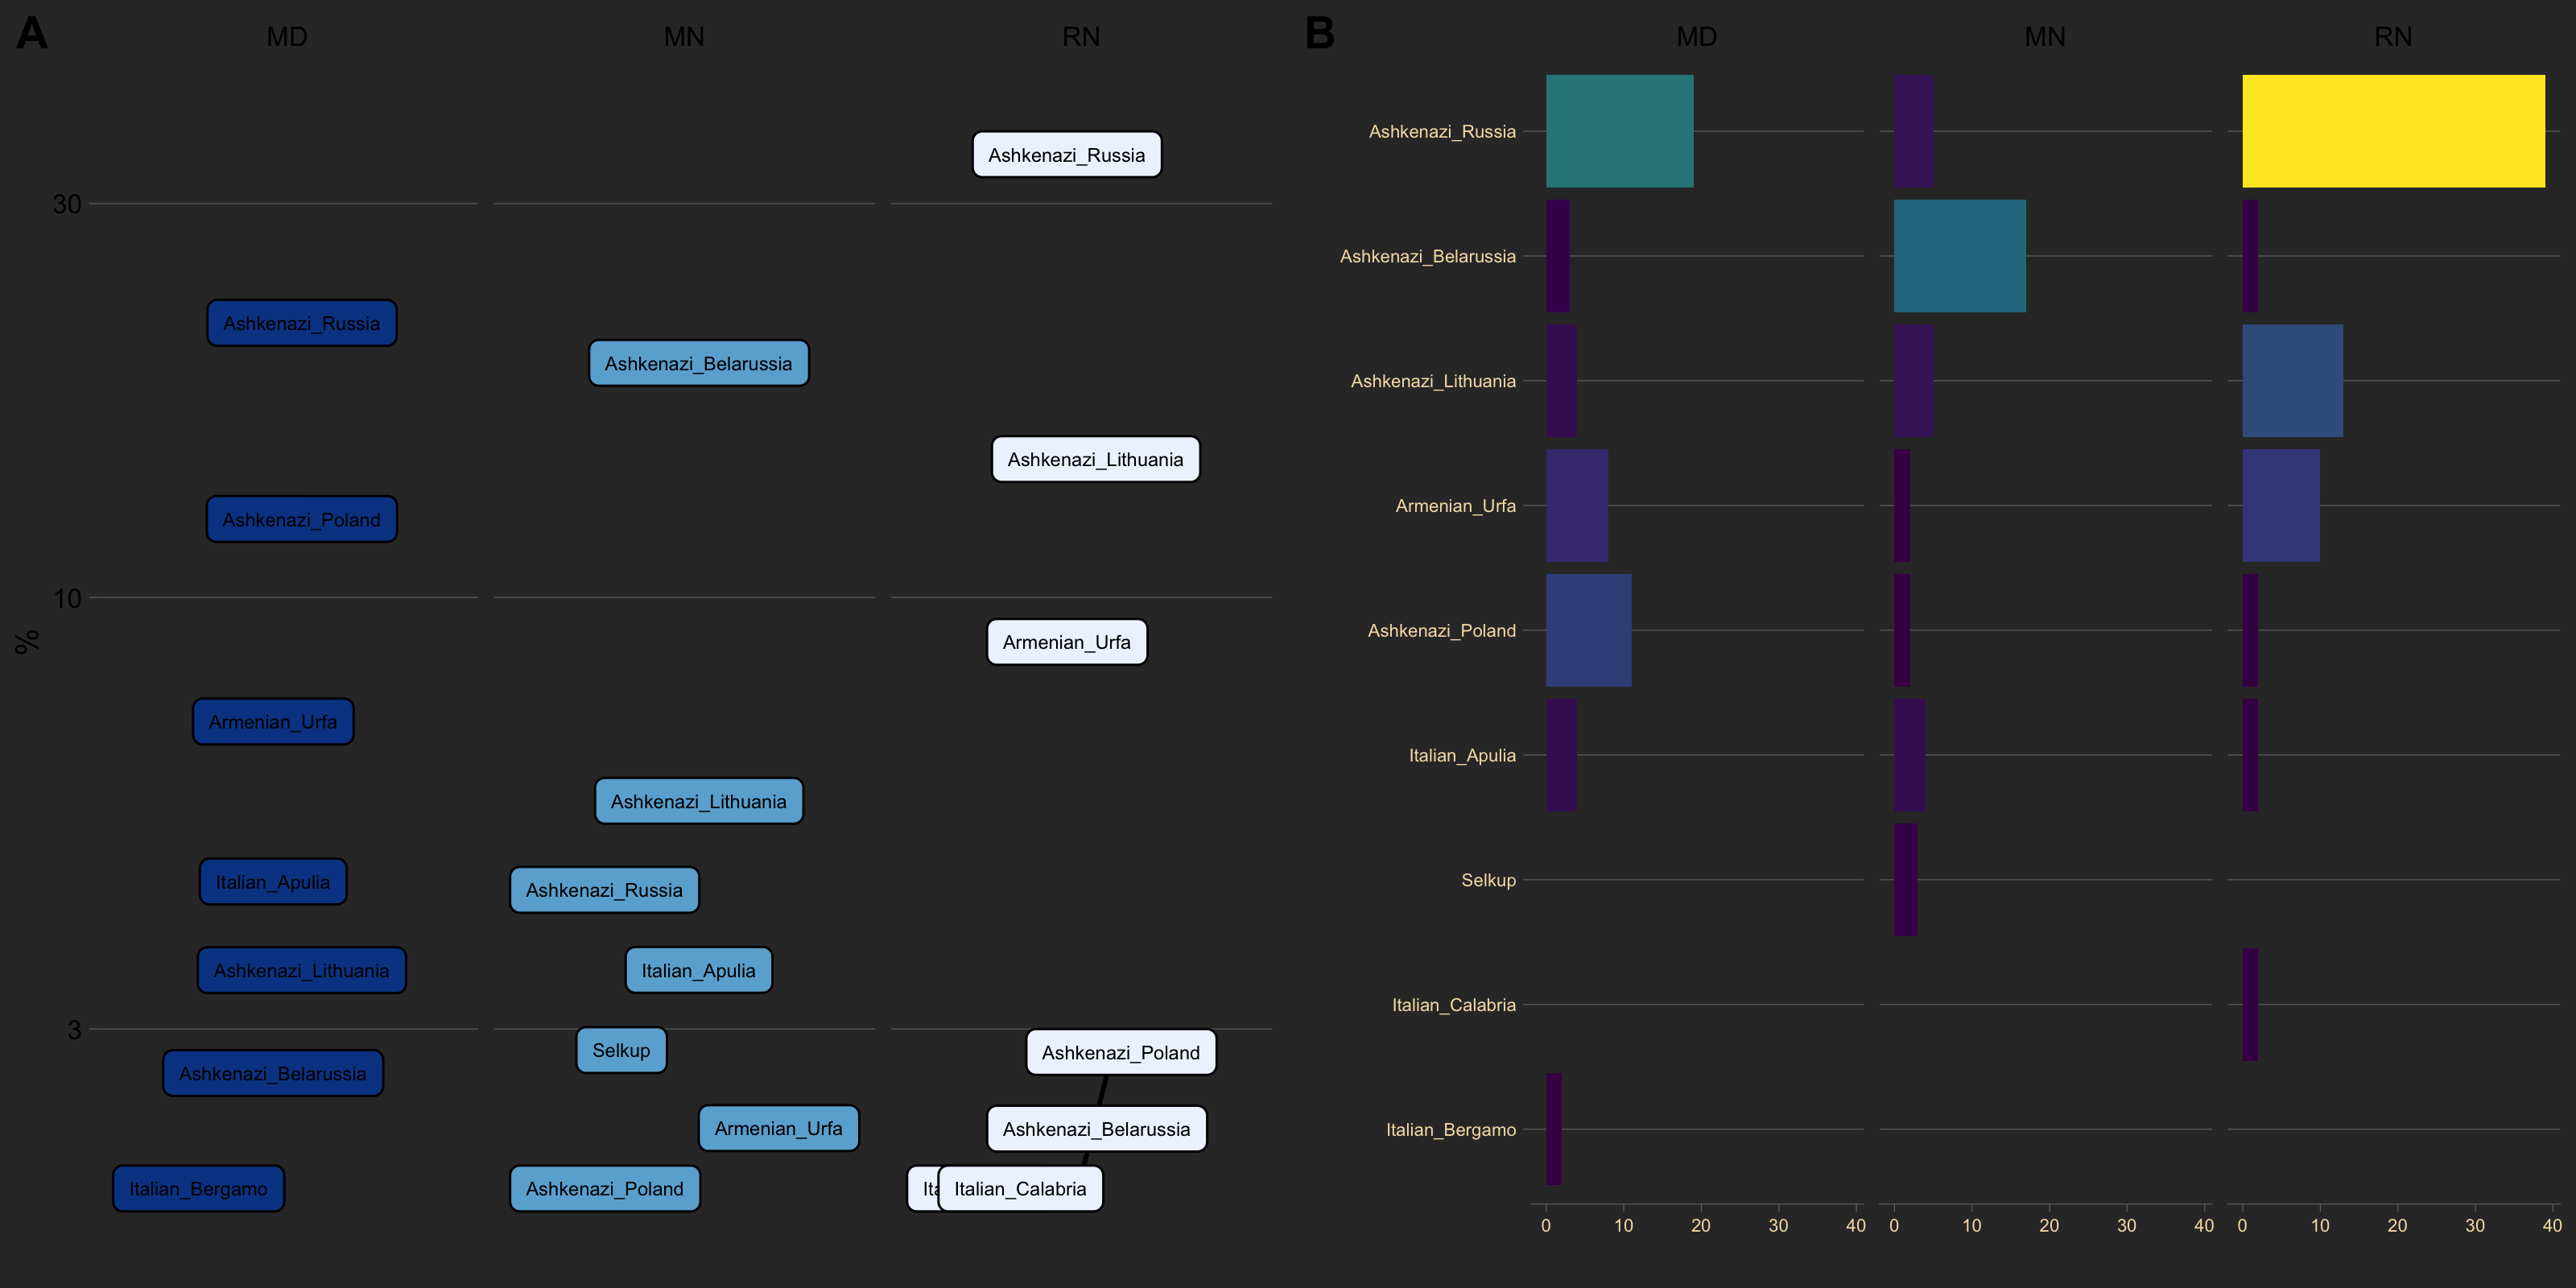

In [353]:
plotfun3(mprd)

In [354]:
#mod = mod %>% mutate(sample = ifelse(str_detect(sample,"_"),str_extract(sample,"^\\w+?(?=_)"),sample))
#modd = mod %>% mutate(sample = ifelse(str_detect(sample,"Ukrain|Lithuan|Ashken|Italian|Spani|Greek|Georgi|Irani|Turki|Frenc|Azerb|Armeni|Basqu"),str_extract(sample,"^\\w+?(?=_)"),sample))
#modd = mod %>% mutate(sample = ifelse(str_detect(sample,"Ukrain|Lithuan|Ashken|Georgi|Azerb|Armeni|Basqu"),str_extract(sample,"^\\w+?(?=_)"),sample))
modd = mod %>% dplyr::filter(!str_detect(sample,"^(Elmo|Tat|Roma|Alta|Aeta|Bata|Erit|Mongo|Saami|Shor|Satna)")) %>% na.omit()
mdl = myfun(modd,e = 0.5,a = 1,l = 10)

[1] "Number of classes: 357"
[1] "Split into test and train samples"
[1] 3361   26
[1] 1121   26
[1] "Starting XGBoost training"
[1]	train-mlogloss:5.405271	test-mlogloss:5.485311 
[26]	train-mlogloss:2.274520	test-mlogloss:3.336576 
[51]	train-mlogloss:1.441169	test-mlogloss:2.963131 
[76]	train-mlogloss:1.058517	test-mlogloss:2.819091 
[100]	train-mlogloss:0.860287	test-mlogloss:2.771613 
# A tibble: 15 × 5
     row label variable value maxval
   <int> <dbl> <chr>    <dbl>  <dbl>
 1   162    53 100      0.221  0.221
 2   258    79 79       0.592  0.592
 3   187    58 8        0.234  0.234
 4   593   168 169      0.194  0.194
 5   876   260 232      0.100  0.100
 6   408   122 2        0.253  0.253
 7   218    73 73       0.488  0.488
 8  1004   317 317      0.962  0.962
 9   372   100 79       0.780  0.780
10   684   201 213      0.165  0.165
11   789   228 225      0.288  0.288
12   594   168 173      0.215  0.215
13   746   215 215      0.708  0.708
14   726   210 210      0.853  0

In [292]:
modd$sample %>% unique %>% sort

[1] "\\Albanian"                           
  [2] "Abazin"                               
  [3] "Abkhasian"                            
  [4] "Abkhasian_Gudauta"                    
  [5] "Adygei"                               
  [6] "Afrikaner"                            
  [7] "Albanian"                             
  [8] "Alevi_Dersim"                         
  [9] "Algerian"                             
 [10] "Armenian_Aintab"                      
 [11] "Armenian_Ararat"                      
 [12] "Armenian_Artsakh"                     
 [13] "Armenian_Erzurum"                     
 [14] "Armenian_Gesaria"                     
 [15] "Armenian_Gurin"                       
 [16] "Armenian_Hemsheni"                    
 [17] "Armenian_Parspatunik"                 
 [18] "Armenian_Syunik"                      
 [19] "Armenian_Urfa"                        
 [20] "Ashkenazi_Belarussia"                 
 [21] "Ashkenazi_Germany"                    
 [22] "Ashkenazi_Lithuania"                  
 [23] "Ashkenazi_Poland"                     
 [24] "Ashkenazi_Russia"                     
 [25] "Ashkenazi_Ukraine"                    
 [26] "Assyrian"                             
 [27] "Austrian"                             
 [28] "Avar"                                 
 [29] "Azerbaijani_Dagestan"                 
 [30] "Azerbaijani_Iran"                     
 [31] "Azerbaijani_Republic"                 
 [32] "Azerbaijani_Republic_Gabala"          
 [33] "Azerbaijani_Republic_Shaki"           
 [34] "Azerbaijani_Turkey"                   
 [35] "Bashkir"                              
 [36] "Basque_Araba"                         
 [37] "Basque_Baztan"                        
 [38] "Basque_Biscay"                        
 [39] "Basque_French"                        
 [40] "Basque_Gipuzkoa"                      
 [41] "Basque_Gipuzkoa_Southwest"            
 [42] "Basque_Lower_Navarre"                 
 [43] "Basque_Navarre_Center"                
 [44] "Basque_Navarre_North"                 
 [45] "Basque_Roncal"                        
 [46] "Basque_Soule"                         
 [47] "Basque_Spanish"                       
 [48] "BedouinA"                             
 [49] "BedouinB"                             
 [50] "Bedzan"                               
 [51] "Belarusian"                           
 [52] "BelgianA"                             
 [53] "BelgianB"                             
 [54] "BelgianC"                             
 [55] "Berber_Algeria"                       
 [56] "Berber_MAR_ERR"                       
 [57] "Berber_MAR_TIZ"                       
 [58] "Berber_Tunisia_Chen"                  
 [59] "Berber_Tunisia_Sen"                   
 [60] "Bosnian"                              
 [61] "Bukharian_Jew"                        
 [62] "Bulgarian"                            
 [63] "Buryat"                               
 [64] "Chechen"                              
 [65] "Chenchu"                              
 [66] "Cherkes"                              
 [67] "Chuvash"                              
 [68] "Circassian"                           
 [69] "Cochin_Jew_A"                         
 [70] "Cochin_Jew_B"                         
 [71] "Cossack_Kuban"                        
 [72] "Cossack_Ukrainian"                    
 [73] "Croatian"                             
 [74] "Cypriot"                              
 [75] "Czech"                                
 [76] "Danish"                               
 [77] "Darginian"                            
 [78] "Druze"                                
 [79] "Dungan"                               
 [80] "Dutch"                                
 [81] "Egyptian"                             
 [82] "EmiratiA"                             
 [83] "EmiratiB"                             
 [84] "EmiratiC"                             
 [85] "English"                              
 [86] "English_Cornwall"                     
 [87] "Erzya"                                


In [316]:
mprd = mypfun(mdl,modd,ppl)

[1] "Using 357 populations"


Joining with `by = join_by(variable)`


   name                   eth  value
1    MD      Ashkenazi_Poland  4.67%
2    MD         Armenian_Urfa  3.86%
3    MD      Ashkenazi_Russia 17.21%
4    MD     Ashkenazi_Germany 11.46%
5    MD   Ashkenazi_Lithuania 10.66%
6    MN   Ashkenazi_Lithuania 43.19%
7    MN      Ashkenazi_Russia  2.59%
8    MN     Ashkenazi_Germany  2.48%
9    MN  Ashkenazi_Belarussia  10.3%
10   RN         Armenian_Urfa  3.17%
11   RN     Ashkenazi_Germany 20.55%
12   RN  Italian_Aosta_Valley  2.14%
13   RN      Italian_Calabria  2.08%
14   RN      Ashkenazi_Russia 18.12%
15   RN   Ashkenazi_Lithuania 10.08%
16   TP        Russian_Ryazan  9.05%
17   TP   Russian_Leshukonsky  4.83%
18   TP Ukrainian_Zakarpattia   4.2%
19   TP  Russian_Krasnoborsky  3.02%
20   TP                 Mansi  2.82%
21   TP               Cypriot  2.35%
22   TP       Ukrainian_Rivne  2.24%


In [355]:
mprd = mypfun2(mdl,modd,ppl %>% dplyr::filter(!str_detect(V1,"TP")))

[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`
`summarise()` has grouped output by 'name'. You can override using the
`.groups` argument.


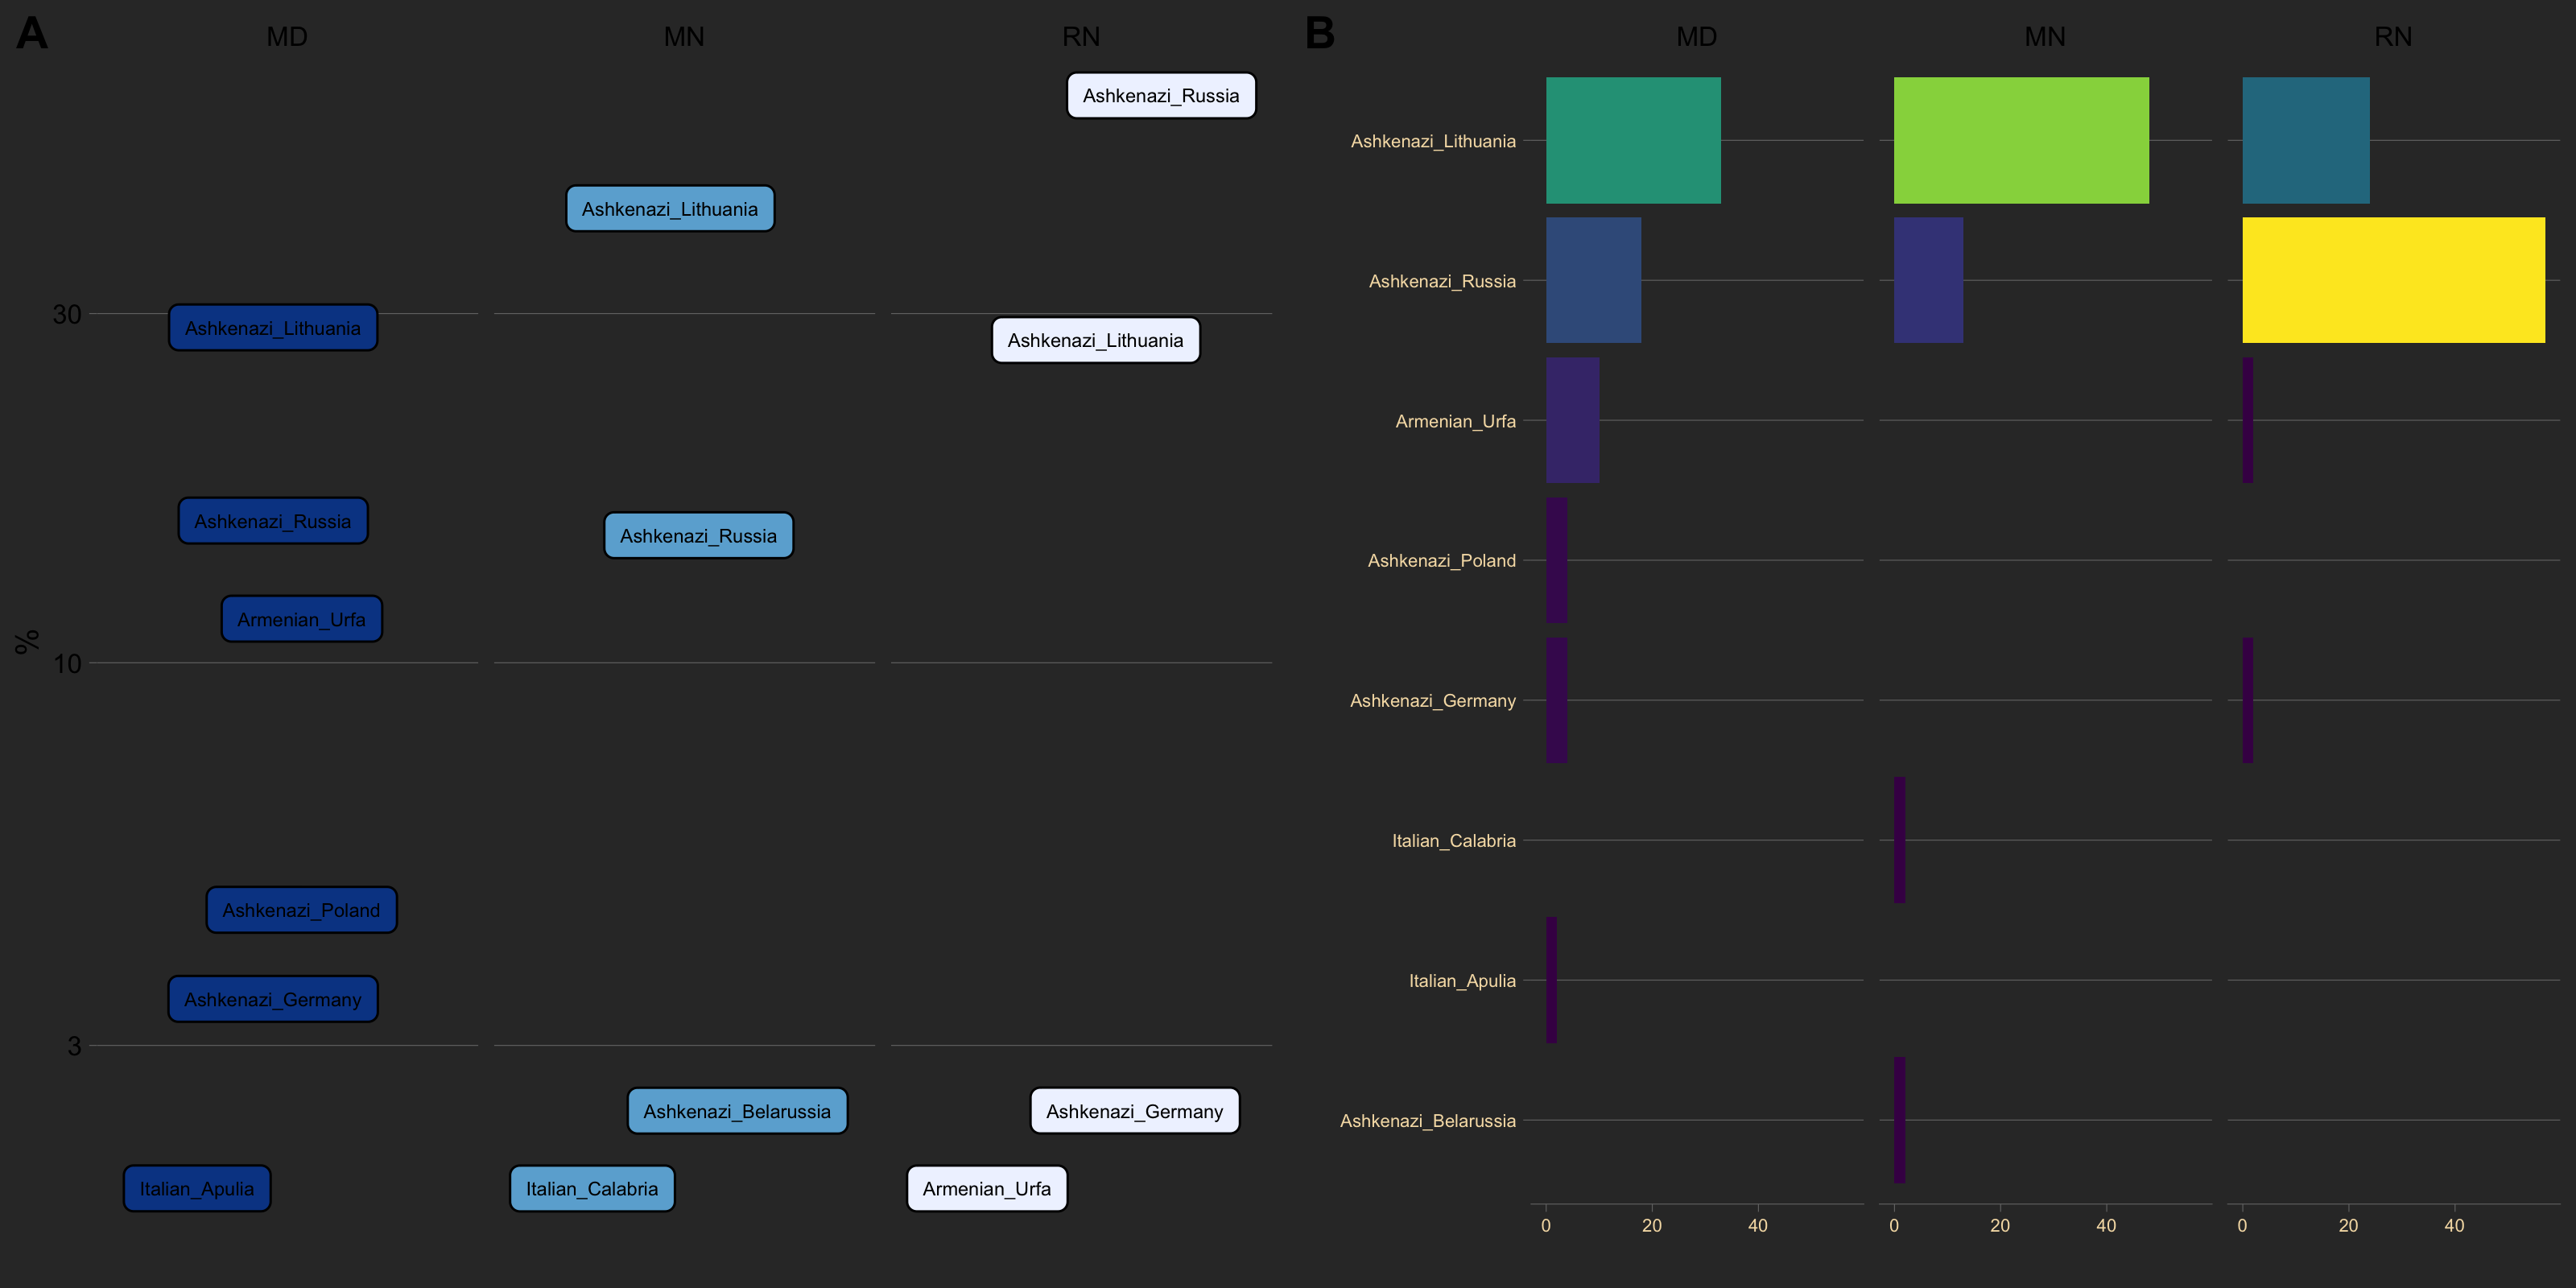

In [356]:
plotfun3(mprd)

Bronze Age

In [360]:
mdl = myfun(na.omit(bad),e = 1,a = 1,l = 10)

[1] "Number of classes: 233"
[1] "Split into test and train samples"
[1] 1068   26
[1] 357  26
[1] "Starting XGBoost training"
[1]	train-mlogloss:4.900663	test-mlogloss:4.976502 
[26]	train-mlogloss:2.255641	test-mlogloss:3.377642 
[51]	train-mlogloss:1.740624	test-mlogloss:3.263587 
[76]	train-mlogloss:1.499630	test-mlogloss:3.238393 
[100]	train-mlogloss:1.371837	test-mlogloss:3.233717 
# A tibble: 15 × 5
     row label variable  value maxval
   <int> <dbl> <chr>     <dbl>  <dbl>
 1   222   132 132      0.0284 0.0284
 2   153    68 68       0.226  0.226 
 3    85    27 27       0.958  0.958 
 4   320   206 19       0.146  0.146 
 5   298   186 186      0.129  0.129 
 6   197   101 68       0.479  0.479 
 7   303   190 186      0.572  0.572 
 8   232   137 137      0.993  0.993 
 9   130    50 19       0.214  0.214 
10   242   139 18       0.0942 0.0942
11    92    28 25       0.446  0.446 
12   257   156 155      0.184  0.184 
13    74    27 27       0.155  0.155 
14   238   137 137 

In [297]:
mprd = mypfun(mdl,bad,ppl)

[1] "Using 233 populations"


Joining with `by = join_by(variable)`


  name              eth  value
1   TP Czech_CordedWare 77.29%
2   TP       Poland_TRB 13.86%


In [361]:
mprd = mypfun2(mdl,bad,ppl %>% dplyr::filter(!str_detect(V1,"TP")))

[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`
`summarise()` has grouped output by 'name'. You can override using the
`.groups` argument.


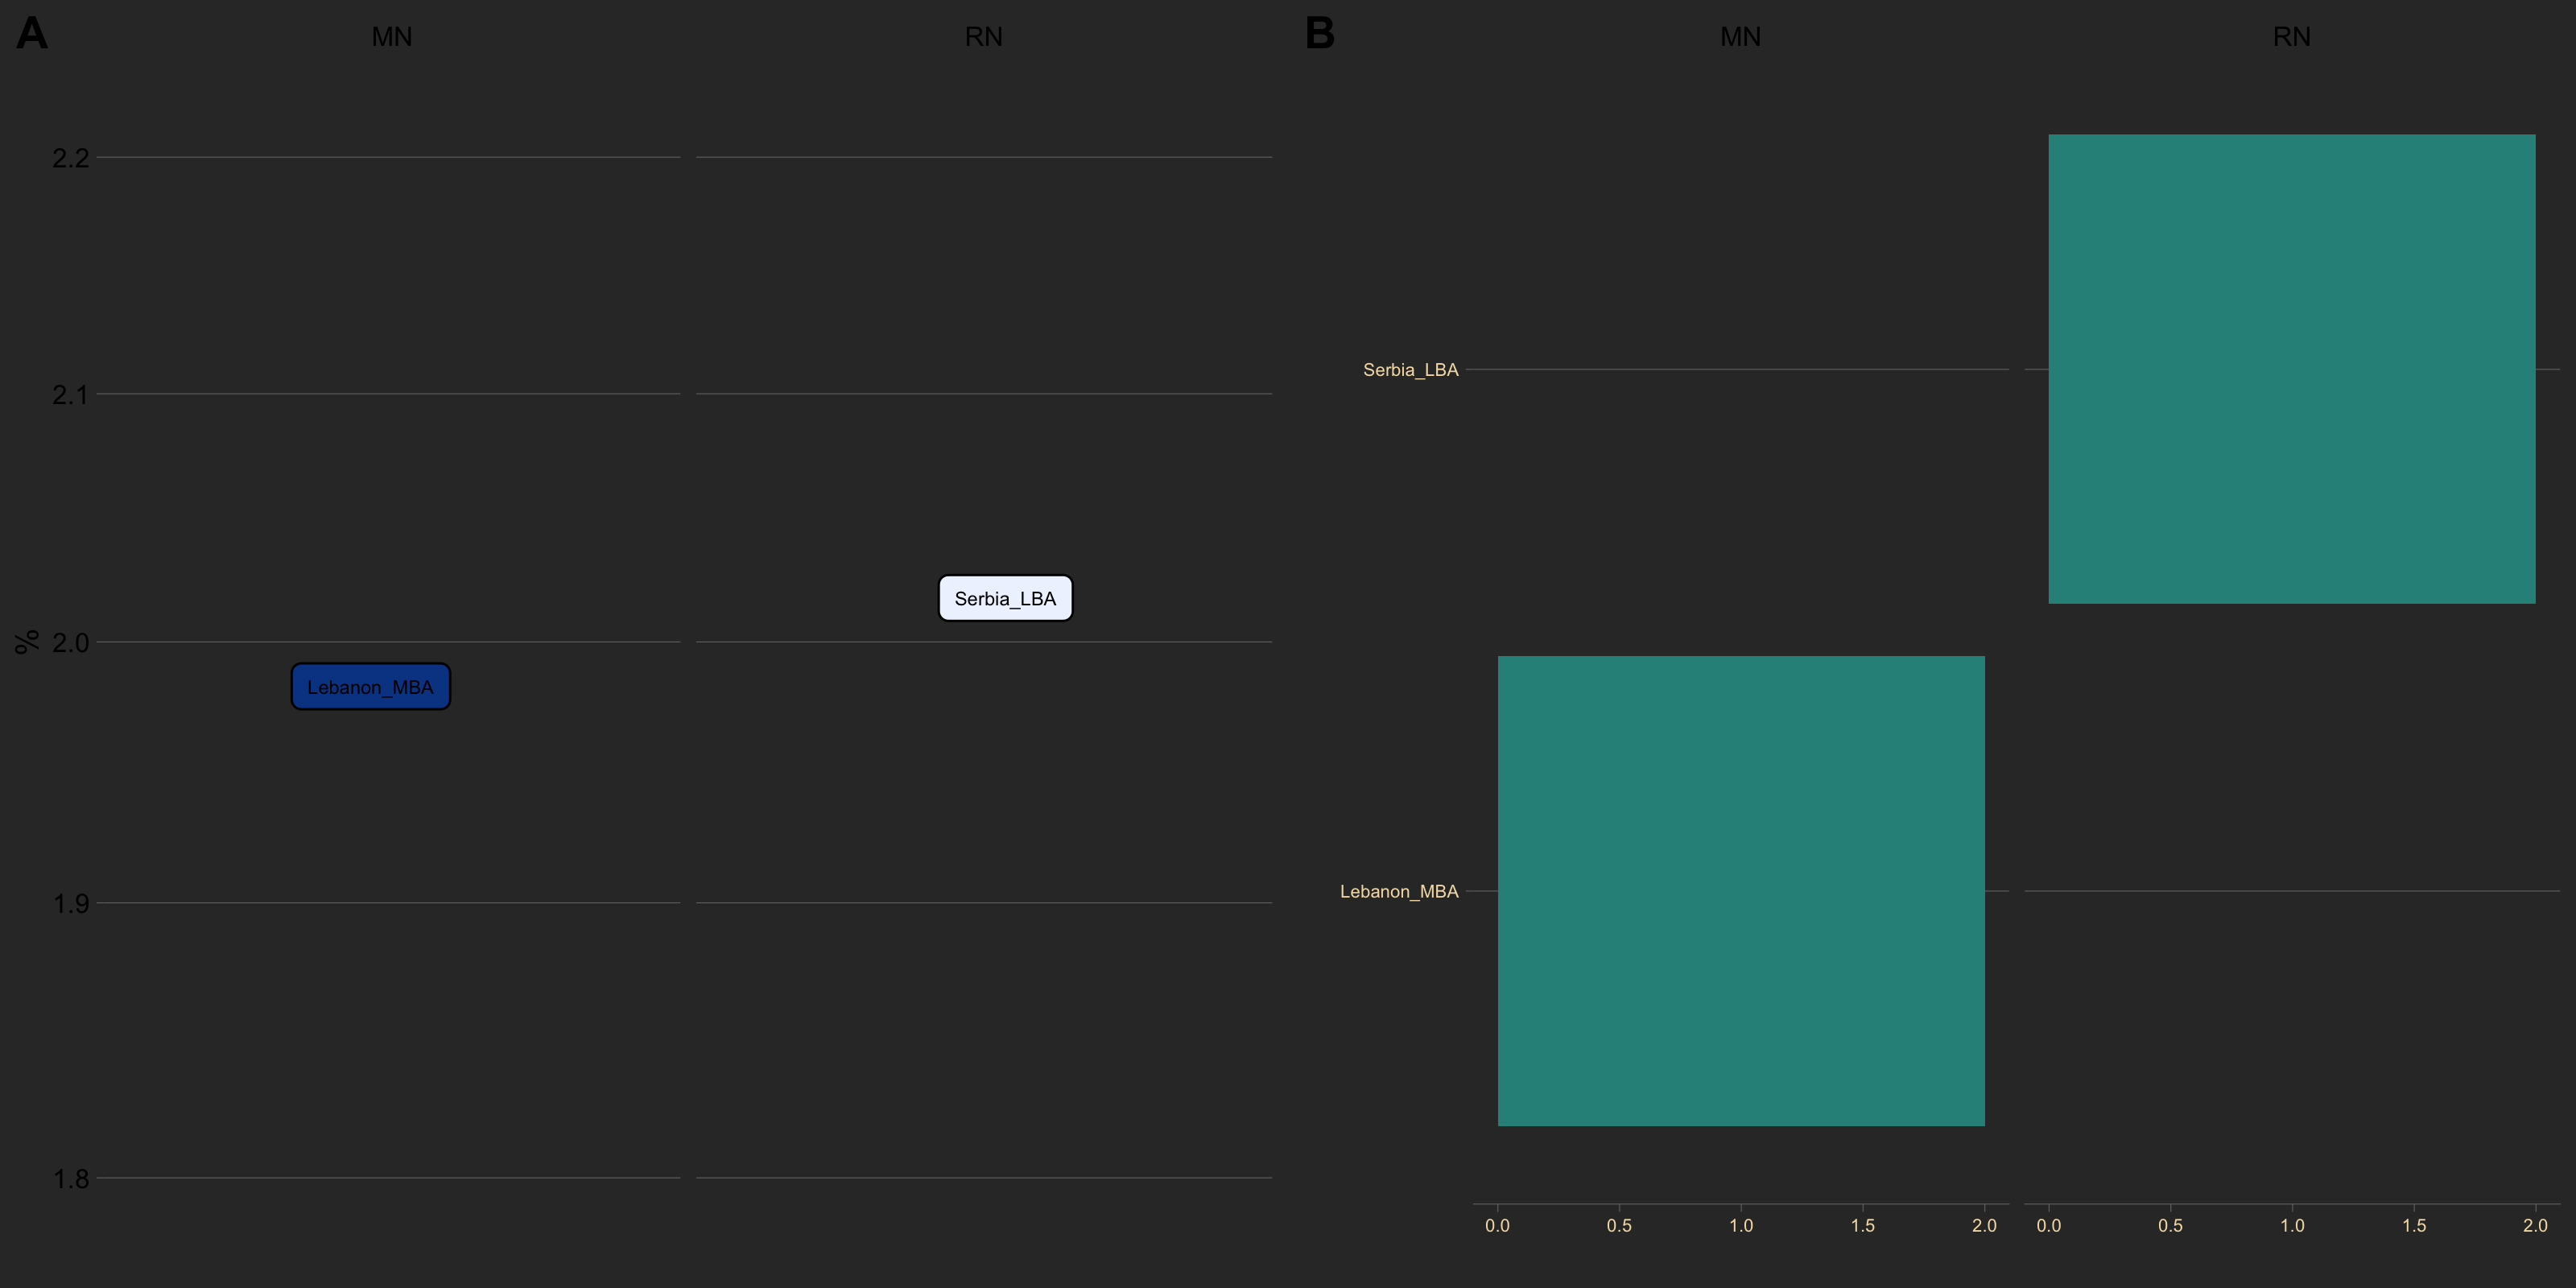

In [362]:
plotfun3(mprd)

In [60]:
mprd = mypfun(mdl,bad,smpls)

[1] "Using 225 populations"


Joining with `by = join_by(variable)`


                     name                     eth value
1    Ashkenazi_Belarussia     Bulgaria_BeliBreyag  4.8%
2    Ashkenazi_Belarussia             Lebanon_MBA  2.3%
3    Ashkenazi_Belarussia             Hungary_MBA  1.5%
4    Ashkenazi_Belarussia Ukraine_GlobularAmphora  1.4%
5    Ashkenazi_Belarussia             Armenia_MBA  1.2%
6     Ashkenazi_Lithuania             Lebanon_MBA  2.2%
7     Ashkenazi_Lithuania        Armenia_Lchashen  1.6%
8     Ashkenazi_Lithuania             Hungary_MBA  1.6%
9     Ashkenazi_Lithuania     Bulgaria_BeliBreyag  1.5%
10    Ashkenazi_Lithuania Ukraine_GlobularAmphora  1.4%
11    Ashkenazi_Lithuania      Slovakia_Mikusovce  1.3%
12    Ashkenazi_Lithuania             Armenia_MBA  1.2%
13    Ashkenazi_Lithuania            Iran_Hasanlu  1.1%
14      Ashkenazi_Ukraine             Lebanon_MBA  2.2%
15      Ashkenazi_Ukraine        Armenia_Lchashen  1.9%
16      Ashkenazi_Ukraine     Bulgaria_BeliBreyag  1.8%
17      Ashkenazi_Ukraine             Hungary_MB

In [61]:
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 400)

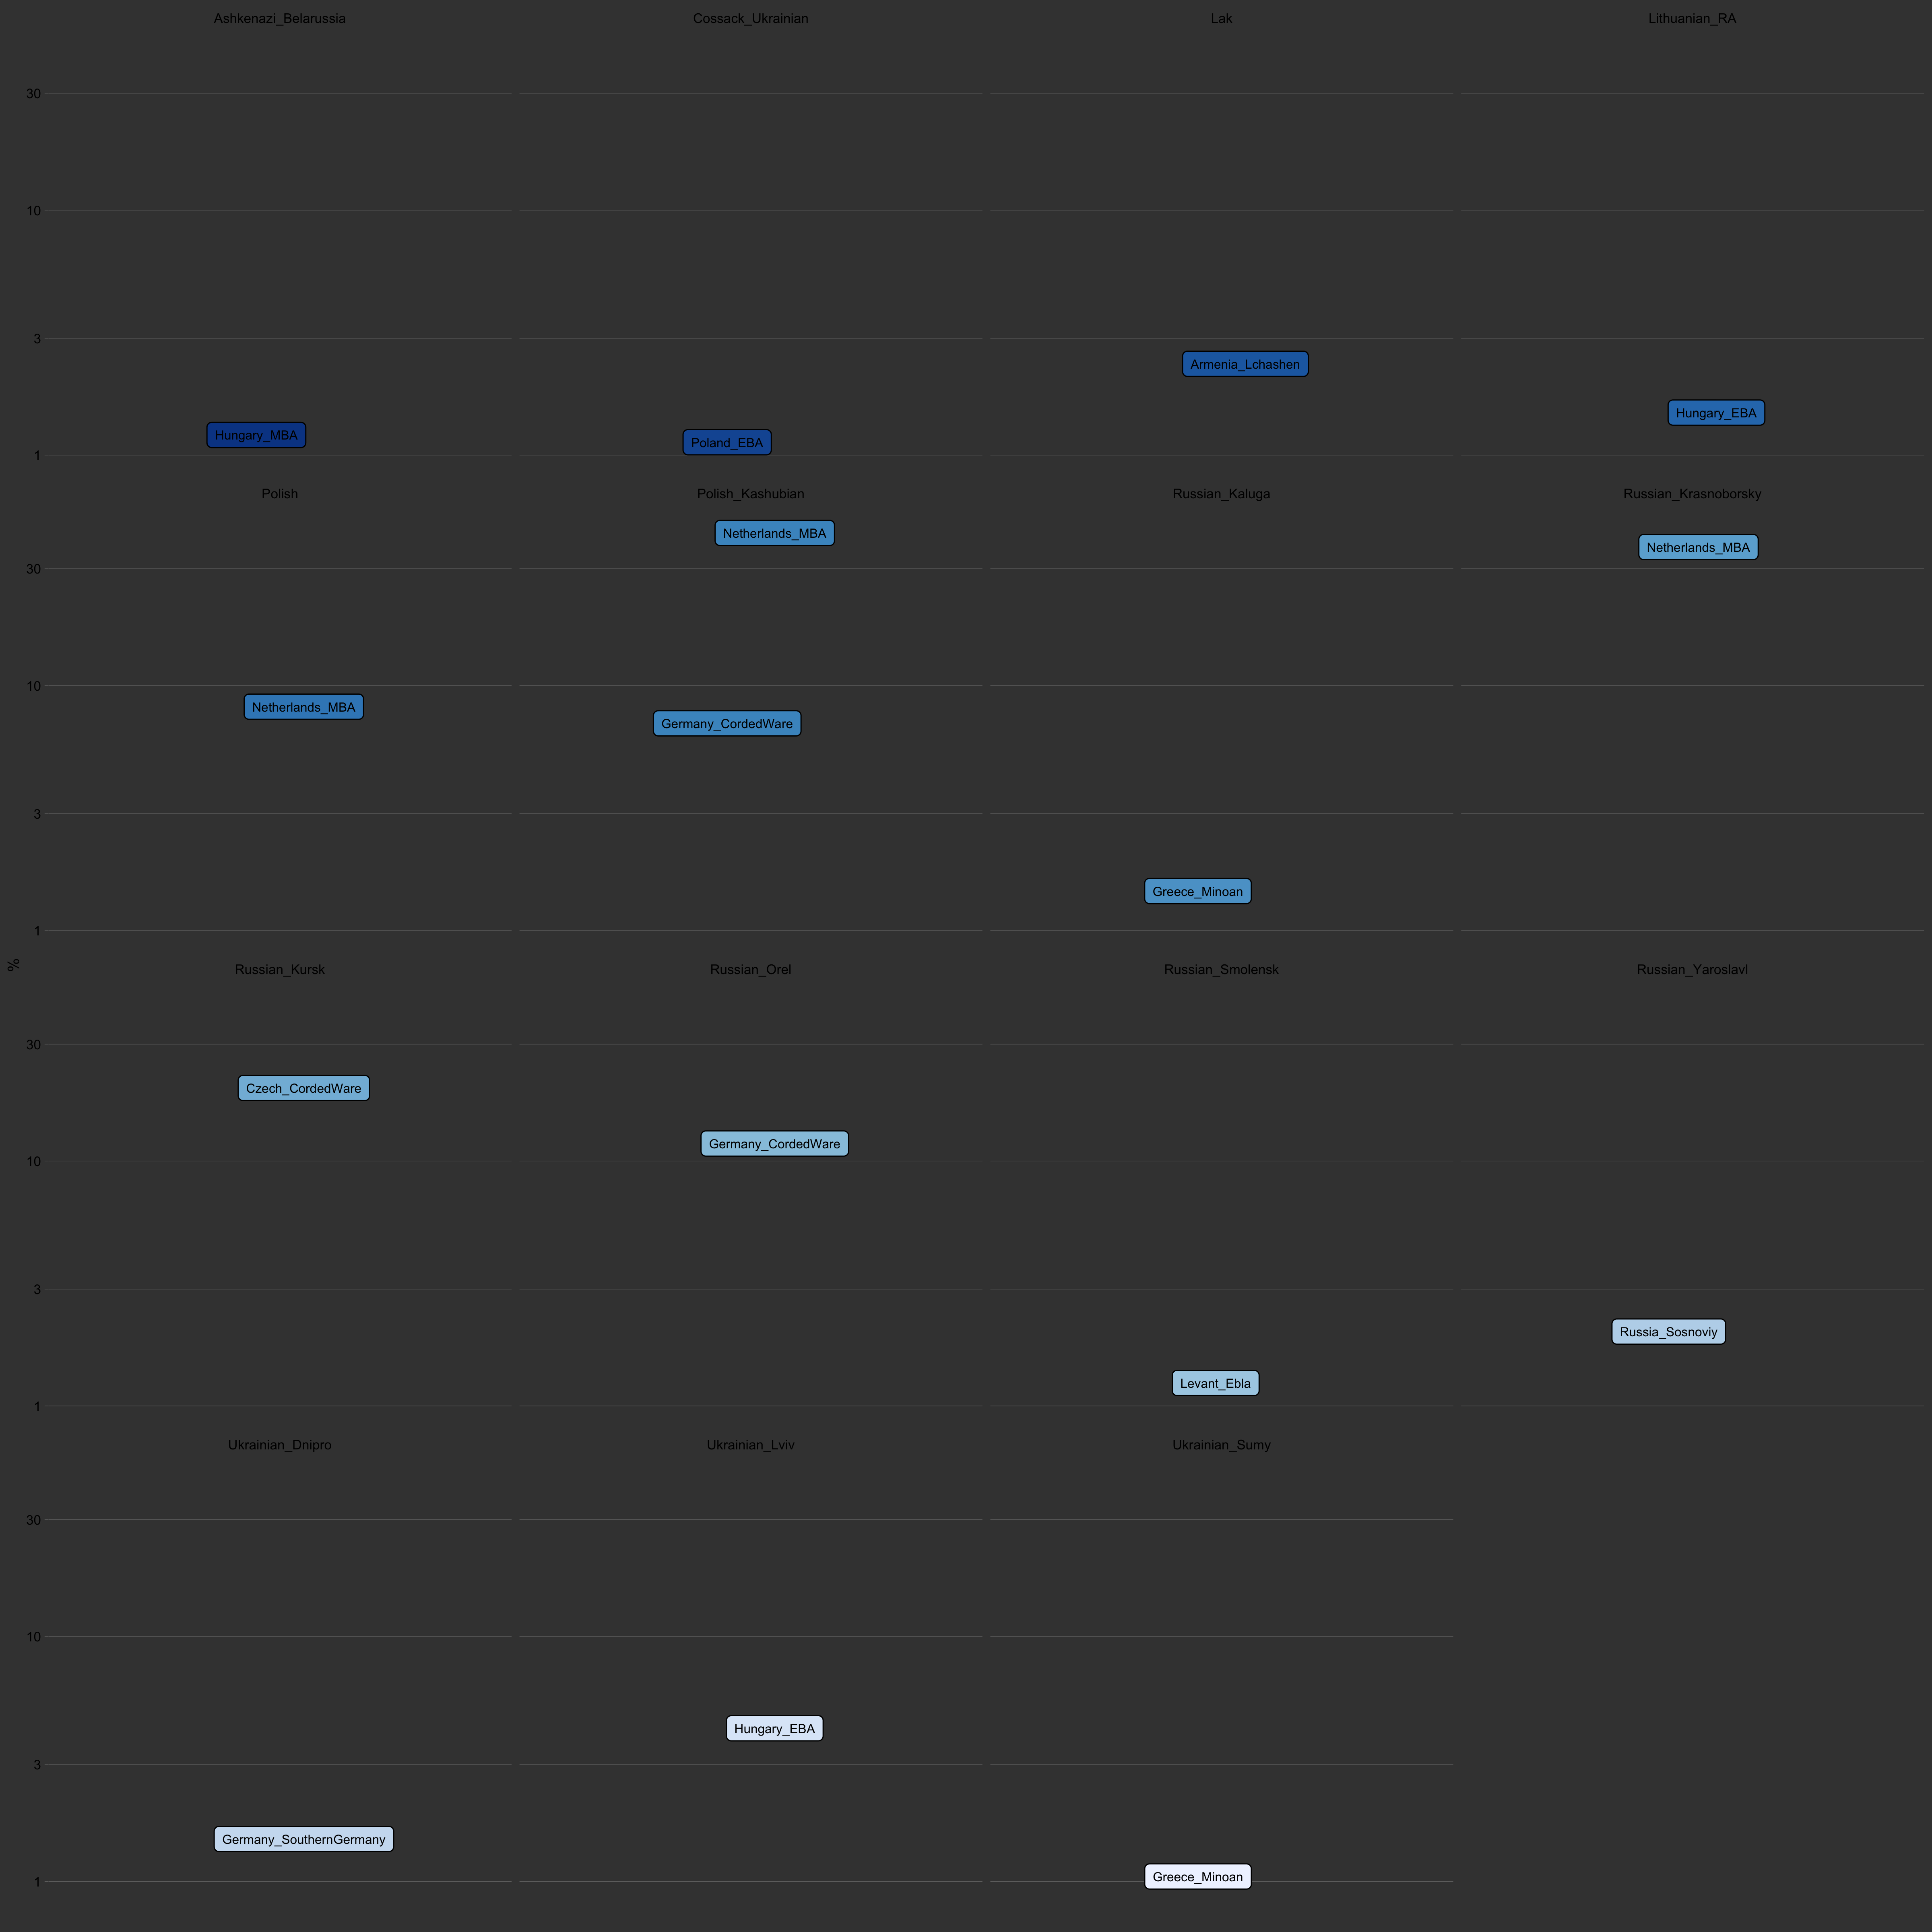

In [62]:
plotfun(mprd %>% sample_n(16),lsz = 2,nrw = 4)

IronAge

In [363]:
mdl = myfun(na.omit(iad),e = 0.5,a = 1,l = 10)

[1] "Number of classes: 129"
[1] "Split into test and train samples"
[1] 591  26
[1] 197  26
[1] "Starting XGBoost training"
[1]	train-mlogloss:4.423578	test-mlogloss:4.471679 
[26]	train-mlogloss:2.355982	test-mlogloss:3.283835 
[51]	train-mlogloss:1.853790	test-mlogloss:3.142395 
[76]	train-mlogloss:1.599425	test-mlogloss:3.086621 
[100]	train-mlogloss:1.447488	test-mlogloss:3.061685 
# A tibble: 15 × 5
     row label variable value maxval
   <int> <dbl> <chr>    <dbl>  <dbl>
 1    31    17 26       0.324  0.324
 2   167    90 26       0.221  0.221
 3   149    76 76       0.350  0.350
 4   189   120 120      0.234  0.234
 5   175   104 104      0.310  0.310
 6    60    25 26       0.838  0.838
 7    52    23 17       0.323  0.323
 8   121    44 17       0.355  0.355
 9    70    26 26       0.716  0.716
10    88    26 26       0.271  0.271
11    77    26 26       0.691  0.691
12   150    77 76       0.673  0.673
13    74    26 26       0.765  0.765
14   145    76 76       0.432  0.432

In [301]:
mprd = mypfun(mdl,iad,ppl)

[1] "Using 129 populations"


Joining with `by = join_by(variable)`


   name                   eth  value
1    MD        Italy_Sardinia  6.01%
2    MD          Iran_Hasanlu  2.48%
3    MD         Greece_Delphi  2.16%
4    MN  France_LesMarmousets     4%
5    MN          Iran_Hasanlu   2.8%
6    MN        Italy_Sardinia   2.4%
7    MN    ChannelIslands_EIA  2.19%
8    MN           Slovakia_IA  2.02%
9    RN        Italy_Sardinia  3.99%
10   RN  France_LesMarmousets  2.93%
11   RN Slovakia_BytcaHrabove  2.88%
12   RN          Iran_Hasanlu  2.47%
13   TP           Hungary_EIA  9.03%
14   TP      Poland_Kowalewko   8.7%
15   TP           Croatia_LIA  6.21%
16   TP             Norway_IA  4.96%
17   TP          Poland_Gaski  3.69%
18   TP      Poland_Maslomecz  2.69%
19   TP Slovakia_BytcaHrabove 12.26%


In [364]:
mprd = mypfun2(mdl,iad,ppl %>% dplyr::filter(!str_detect(V1,"TP")))

[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`
`summarise()` has grouped output by 'name'. You can override using the
`.groups` argument.


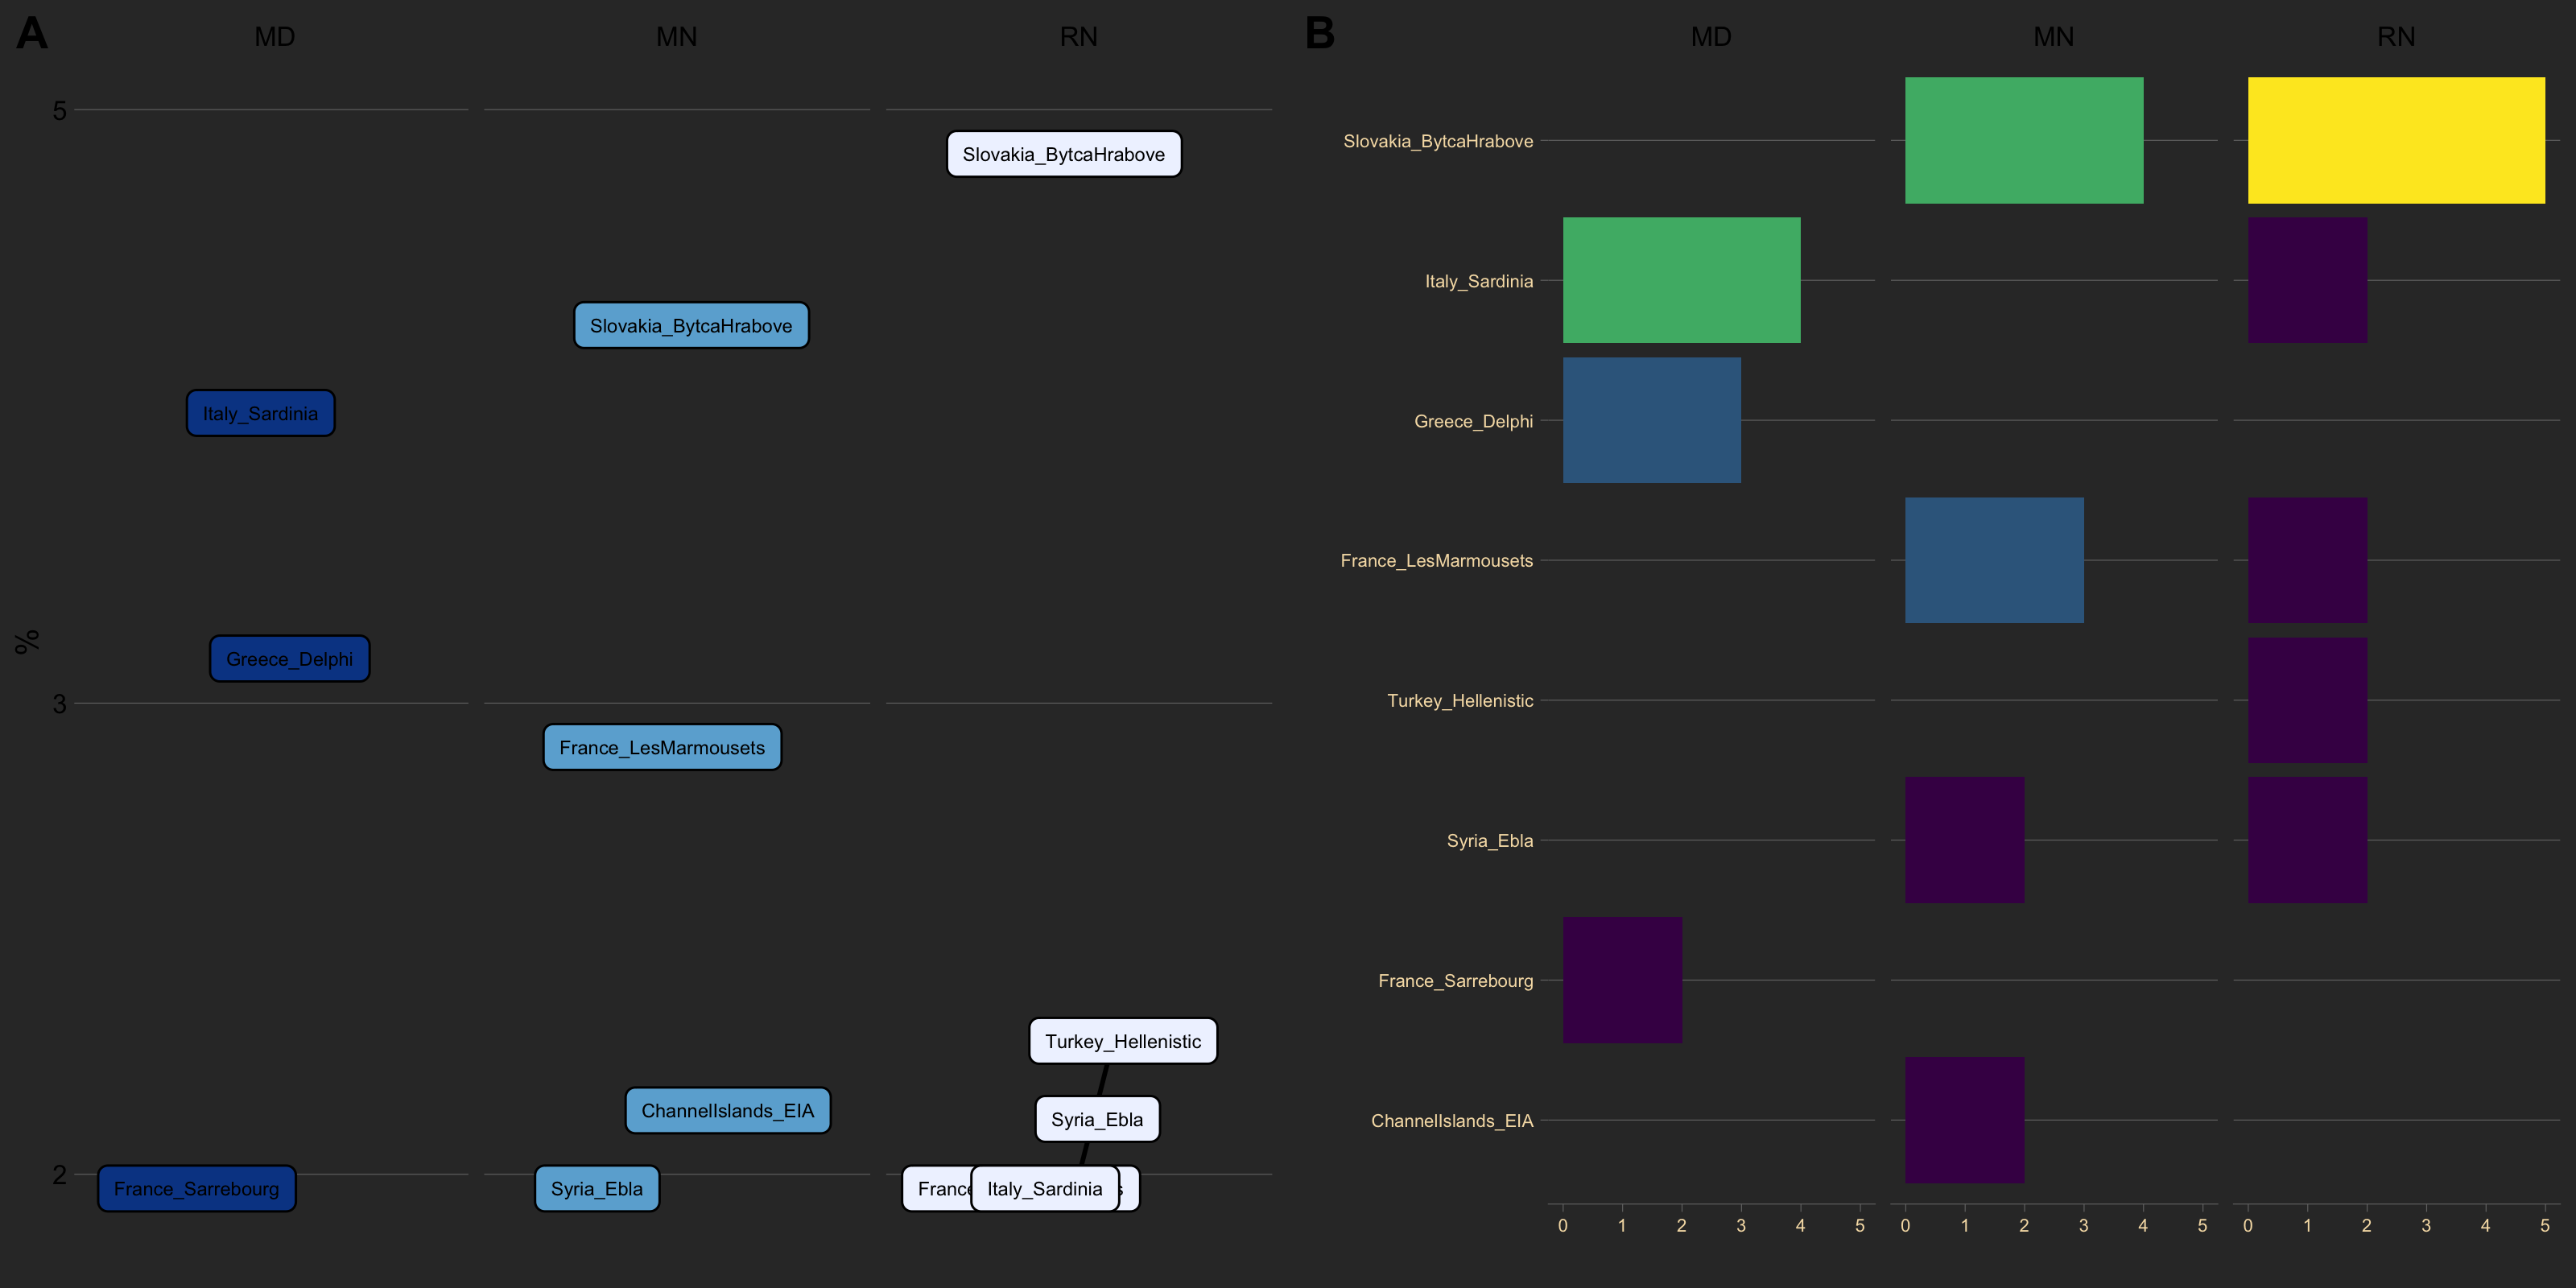

In [365]:
plotfun3(mprd)

In [67]:
mprd = mypfun(mdl,iad,smpls)

[1] "Using 124 populations"


Joining with `by = join_by(variable)`


                     name                           eth value
1    Ashkenazi_Belarussia                   Armenia_LBA  1.4%
2    Ashkenazi_Belarussia                 Italy_Tuscany  1.4%
3    Ashkenazi_Belarussia                  Iran_Hasanlu  1.4%
4    Ashkenazi_Belarussia                   Slovakia_IA  1.3%
5    Ashkenazi_Belarussia          France_LesMarmousets  1.3%
6    Ashkenazi_Belarussia                   Italy_Lazio  1.2%
7    Ashkenazi_Belarussia           Kyrgyzstan_TianShan  1.1%
8    Ashkenazi_Belarussia             Moldova_Cimmerian  1.1%
9    Ashkenazi_Belarussia              Kazakstan_Sargat  1.1%
10   Ashkenazi_Belarussia                     Spain_EIA  1.1%
11   Ashkenazi_Belarussia                     Israel_IA    1%
12   Ashkenazi_Belarussia               Iran_HajjiFiruz    1%
13   Ashkenazi_Belarussia                 Montenegro_IA    1%
14   Ashkenazi_Belarussia                  Scotland_MIA    1%
15   Ashkenazi_Belarussia                  Mongolia_Uvs    1%
16   Ash

In [204]:
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 400)

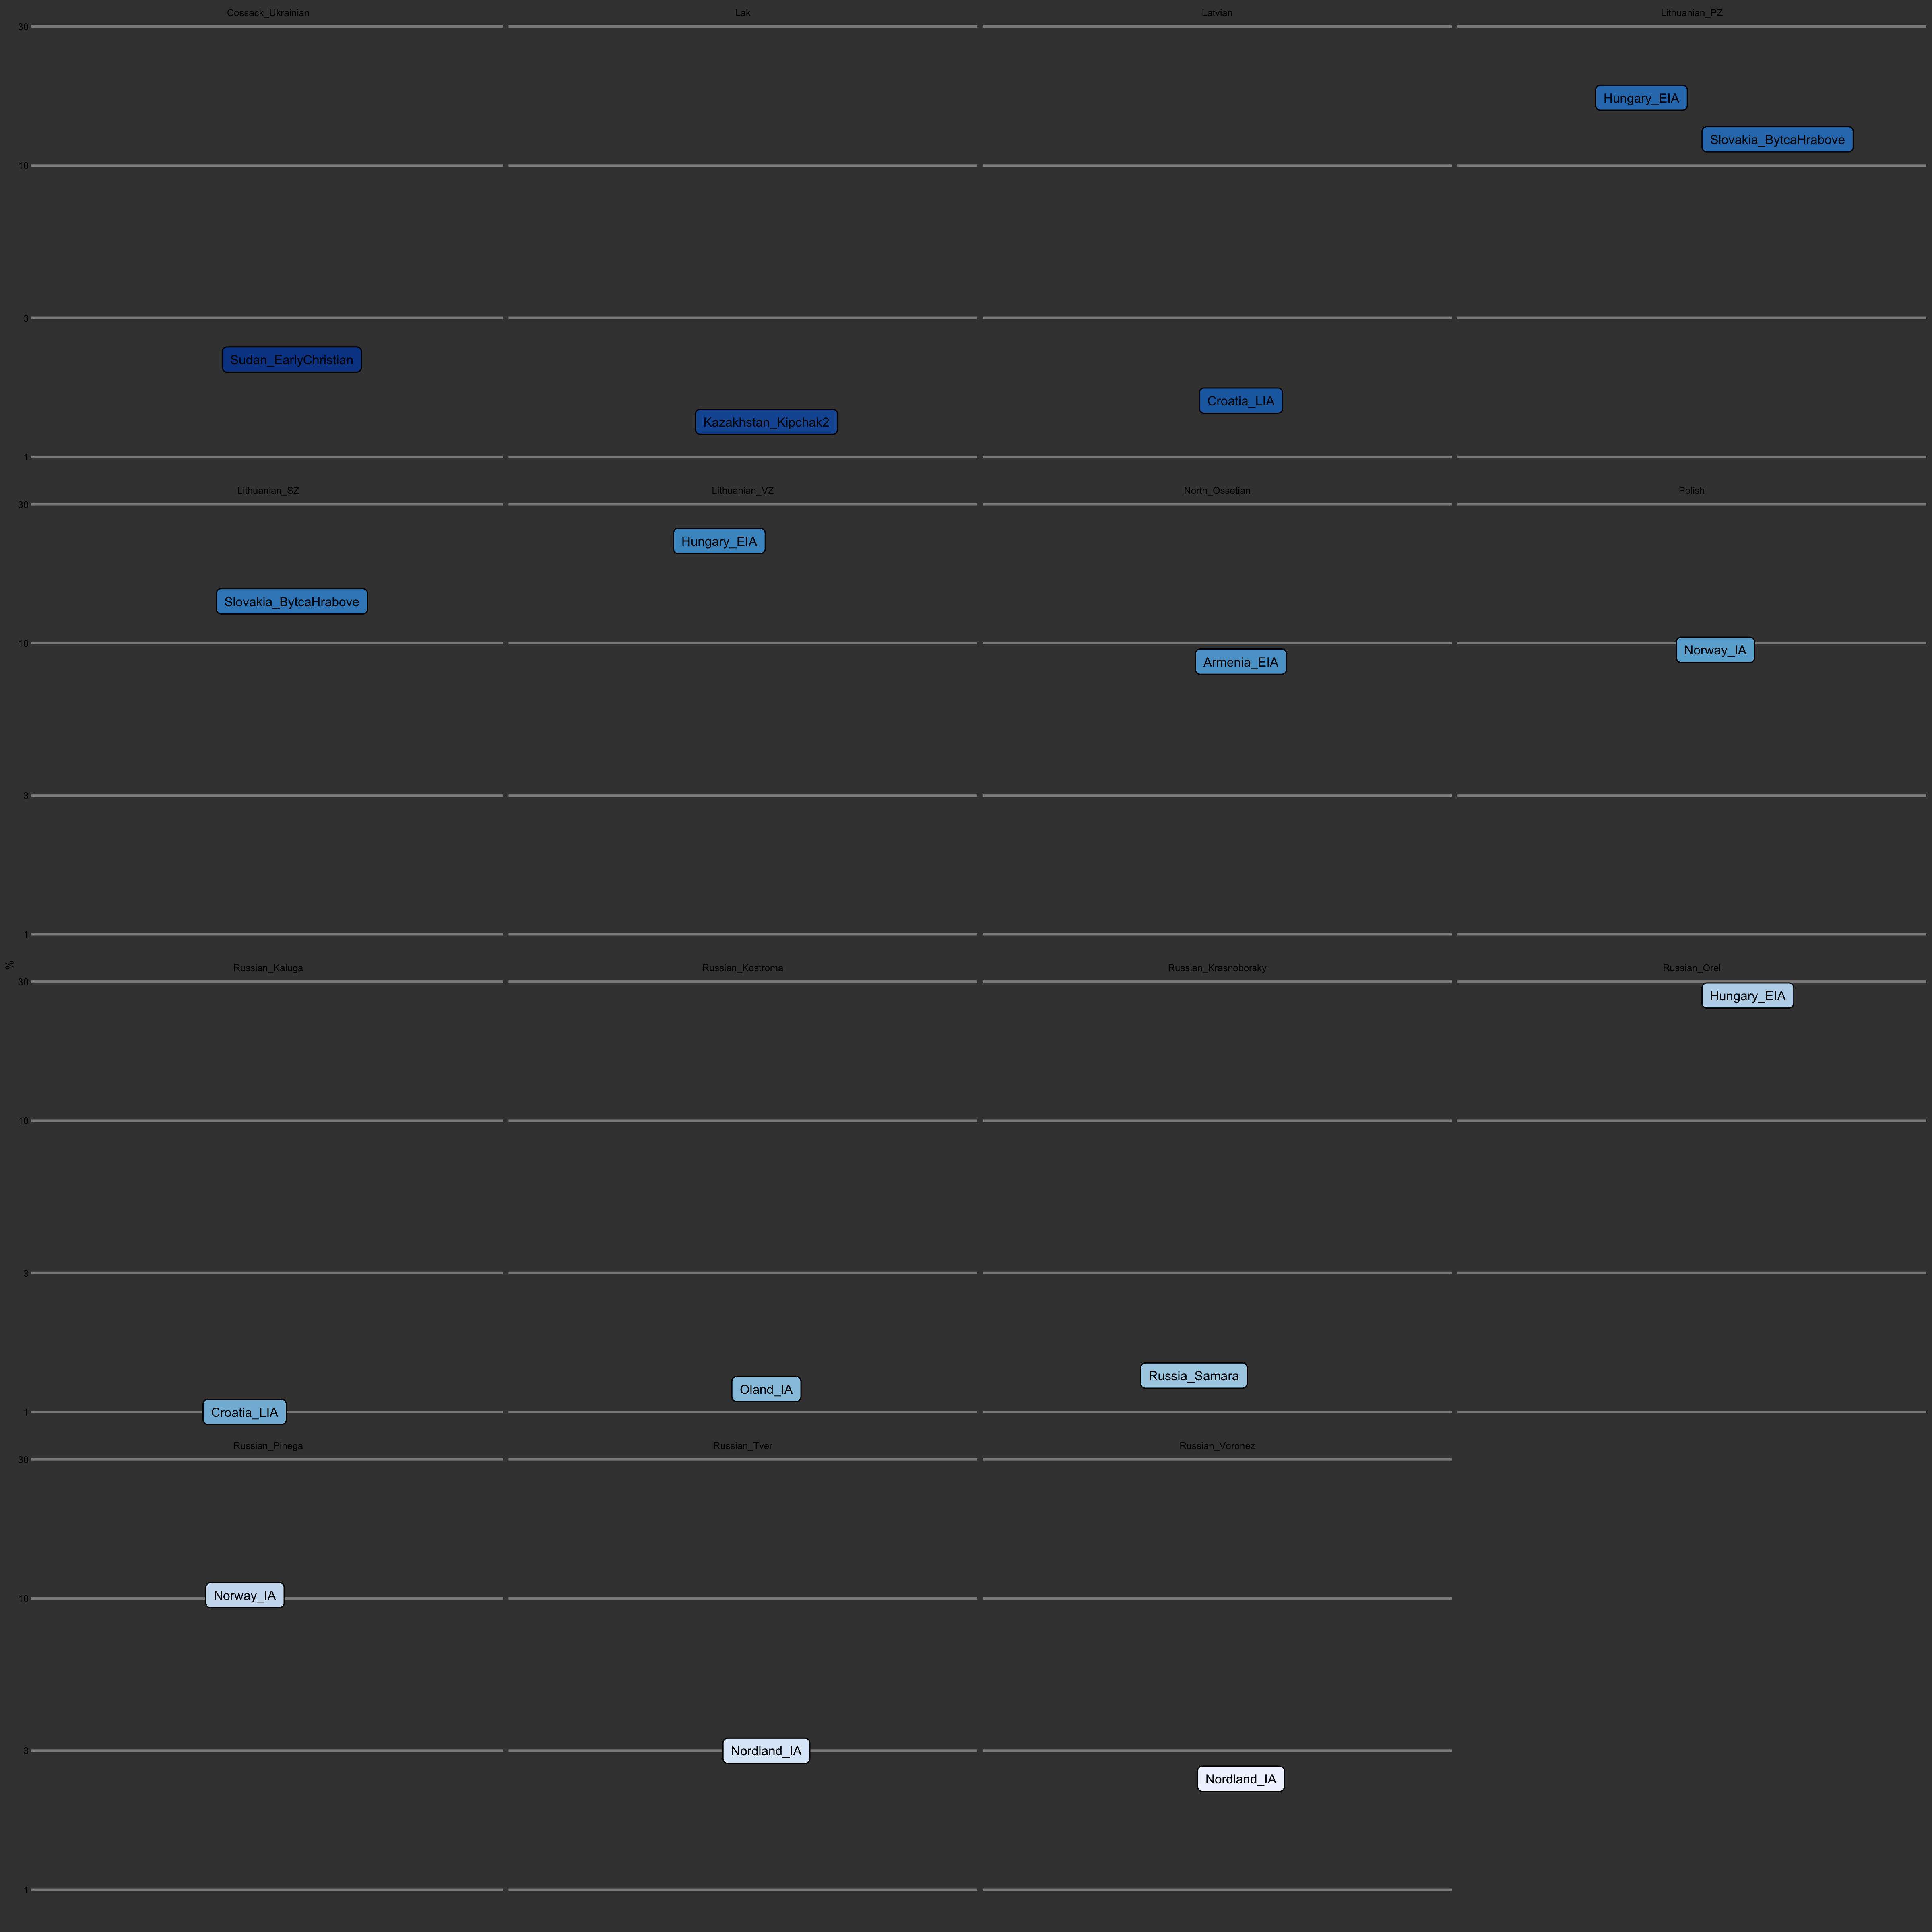

In [205]:
plotfun(mprd %>% sample_n(16),lsz = 2,nrw = 4)

Middle Ages

In [366]:
mdl = myfun(na.omit(mad),e = 1,a = 0,l = 15)

[1] "Number of classes: 131"
[1] "Split into test and train samples"
[1] 727  26
[1] 243  26
[1] "Starting XGBoost training"
[1]	train-mlogloss:4.285235	test-mlogloss:4.304402 
[26]	train-mlogloss:1.625317	test-mlogloss:3.205944 
[51]	train-mlogloss:1.013325	test-mlogloss:3.228859 
[76]	train-mlogloss:0.751705	test-mlogloss:3.279870 
[100]	train-mlogloss:0.628779	test-mlogloss:3.305795 
# A tibble: 15 × 5
     row label variable  value maxval
   <int> <dbl> <chr>     <dbl>  <dbl>
 1    30    14 119      0.211  0.211 
 2   139    65 61       0.121  0.121 
 3   208   119 36       0.947  0.947 
 4   214   119 12       0.553  0.553 
 5   122    44 18       0.306  0.306 
 6    51    14 12       0.280  0.280 
 7   187   104 44       0.320  0.320 
 8    40    14 12       0.700  0.700 
 9   168    86 12       0.328  0.328 
10   112    36 12       0.857  0.857 
11    99    30 14       0.723  0.723 
12    93    30 119      0.345  0.345 
13    47    14 119      0.910  0.910 
14    78    23 36    

In [227]:
mprd = mypfun(mdl,mad,ppl)

[1] "Using 131 populations"


Joining with `by = join_by(variable)`


   name                       eth  value
1    MD Turkey_SoutheastByzantine  4.16%
2    MD           Turkey_Medieval  3.72%
3    MD         Syria_TellMasaikh  3.29%
4    MD          Portugal_Miroico  2.07%
5    MD               Italy_Lazio  10.6%
6    MN               Italy_Lazio 69.69%
7    RN               Italy_Lazio  59.3%
8    RN Turkey_SoutheastByzantine  2.44%
9    TP        Sweden_EarlyViking  8.12%
10   TP            Poland_Konskie 30.76%
11   TP           Poland_Balczewo  3.35%
12   TP            Denmark_Viking  2.41%
13   TP       Poland_Dziekanowice  2.21%


In [367]:
mprd = mypfun2(mdl,mad,ppl %>% dplyr::filter(!str_detect(V1,"TP")))

[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`
`summarise()` has grouped output by 'name'. You can override using the
`.groups` argument.


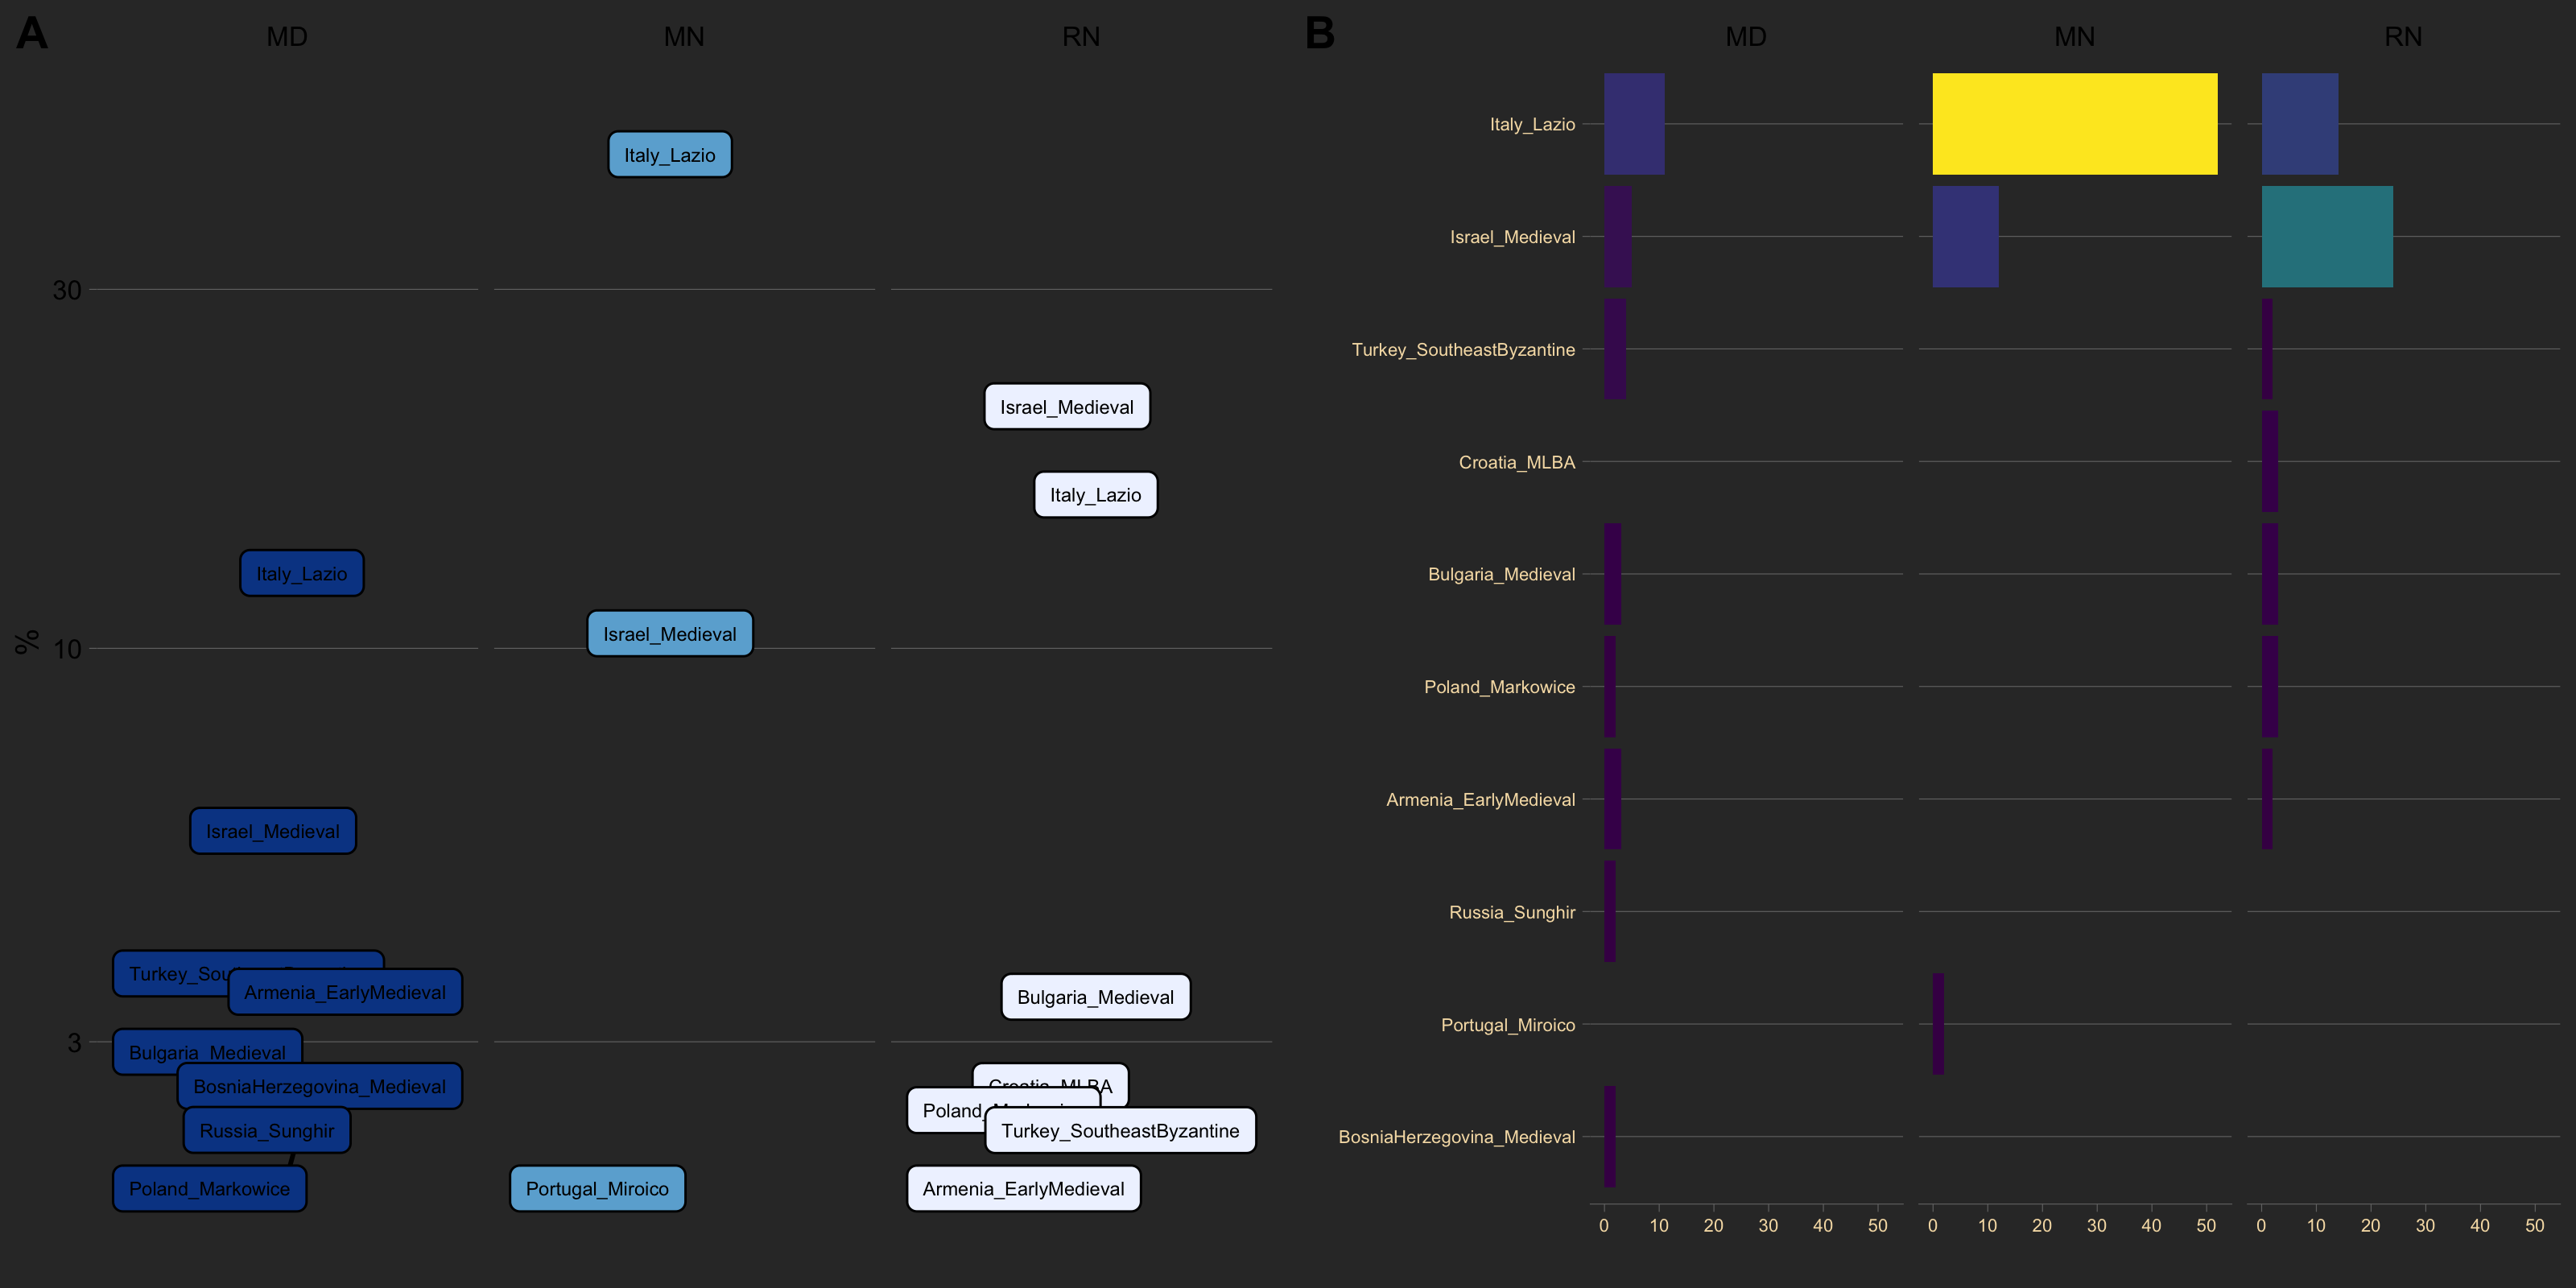

In [368]:
plotfun3(mprd)

In [93]:
mprd = mypfun(mdl,mad,smpls)

[1] "Using 163 populations"


Joining with `by = join_by(variable)`


                     name                           eth value
1    Ashkenazi_Belarussia                   Italy_Lazio 66.9%
2     Ashkenazi_Lithuania                   Italy_Lazio 51.7%
3     Ashkenazi_Lithuania               Kyrgyzstan_Saka  1.6%
4     Ashkenazi_Lithuania               Israel_Medieval  1.5%
5     Ashkenazi_Lithuania              Portugal_Miroico  1.1%
6     Ashkenazi_Lithuania    BosniaHerzegovina_Medieval    1%
7       Ashkenazi_Ukraine                   Italy_Lazio 51.2%
8       Ashkenazi_Ukraine               Kyrgyzstan_Saka  1.7%
9              Belarusian                Poland_Konskie    7%
10             Belarusian                 Poland_Milicz  6.4%
11             Belarusian            Sweden_EarlyViking  5.3%
12             Belarusian                Poland_Niemcza  3.6%
13             Belarusian                    Poland_Lad  3.3%
14             Belarusian             Poland_Oblaczkowo  3.3%
15             Belarusian               Poland_Balczewo  2.9%
16      

In [212]:
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 400)

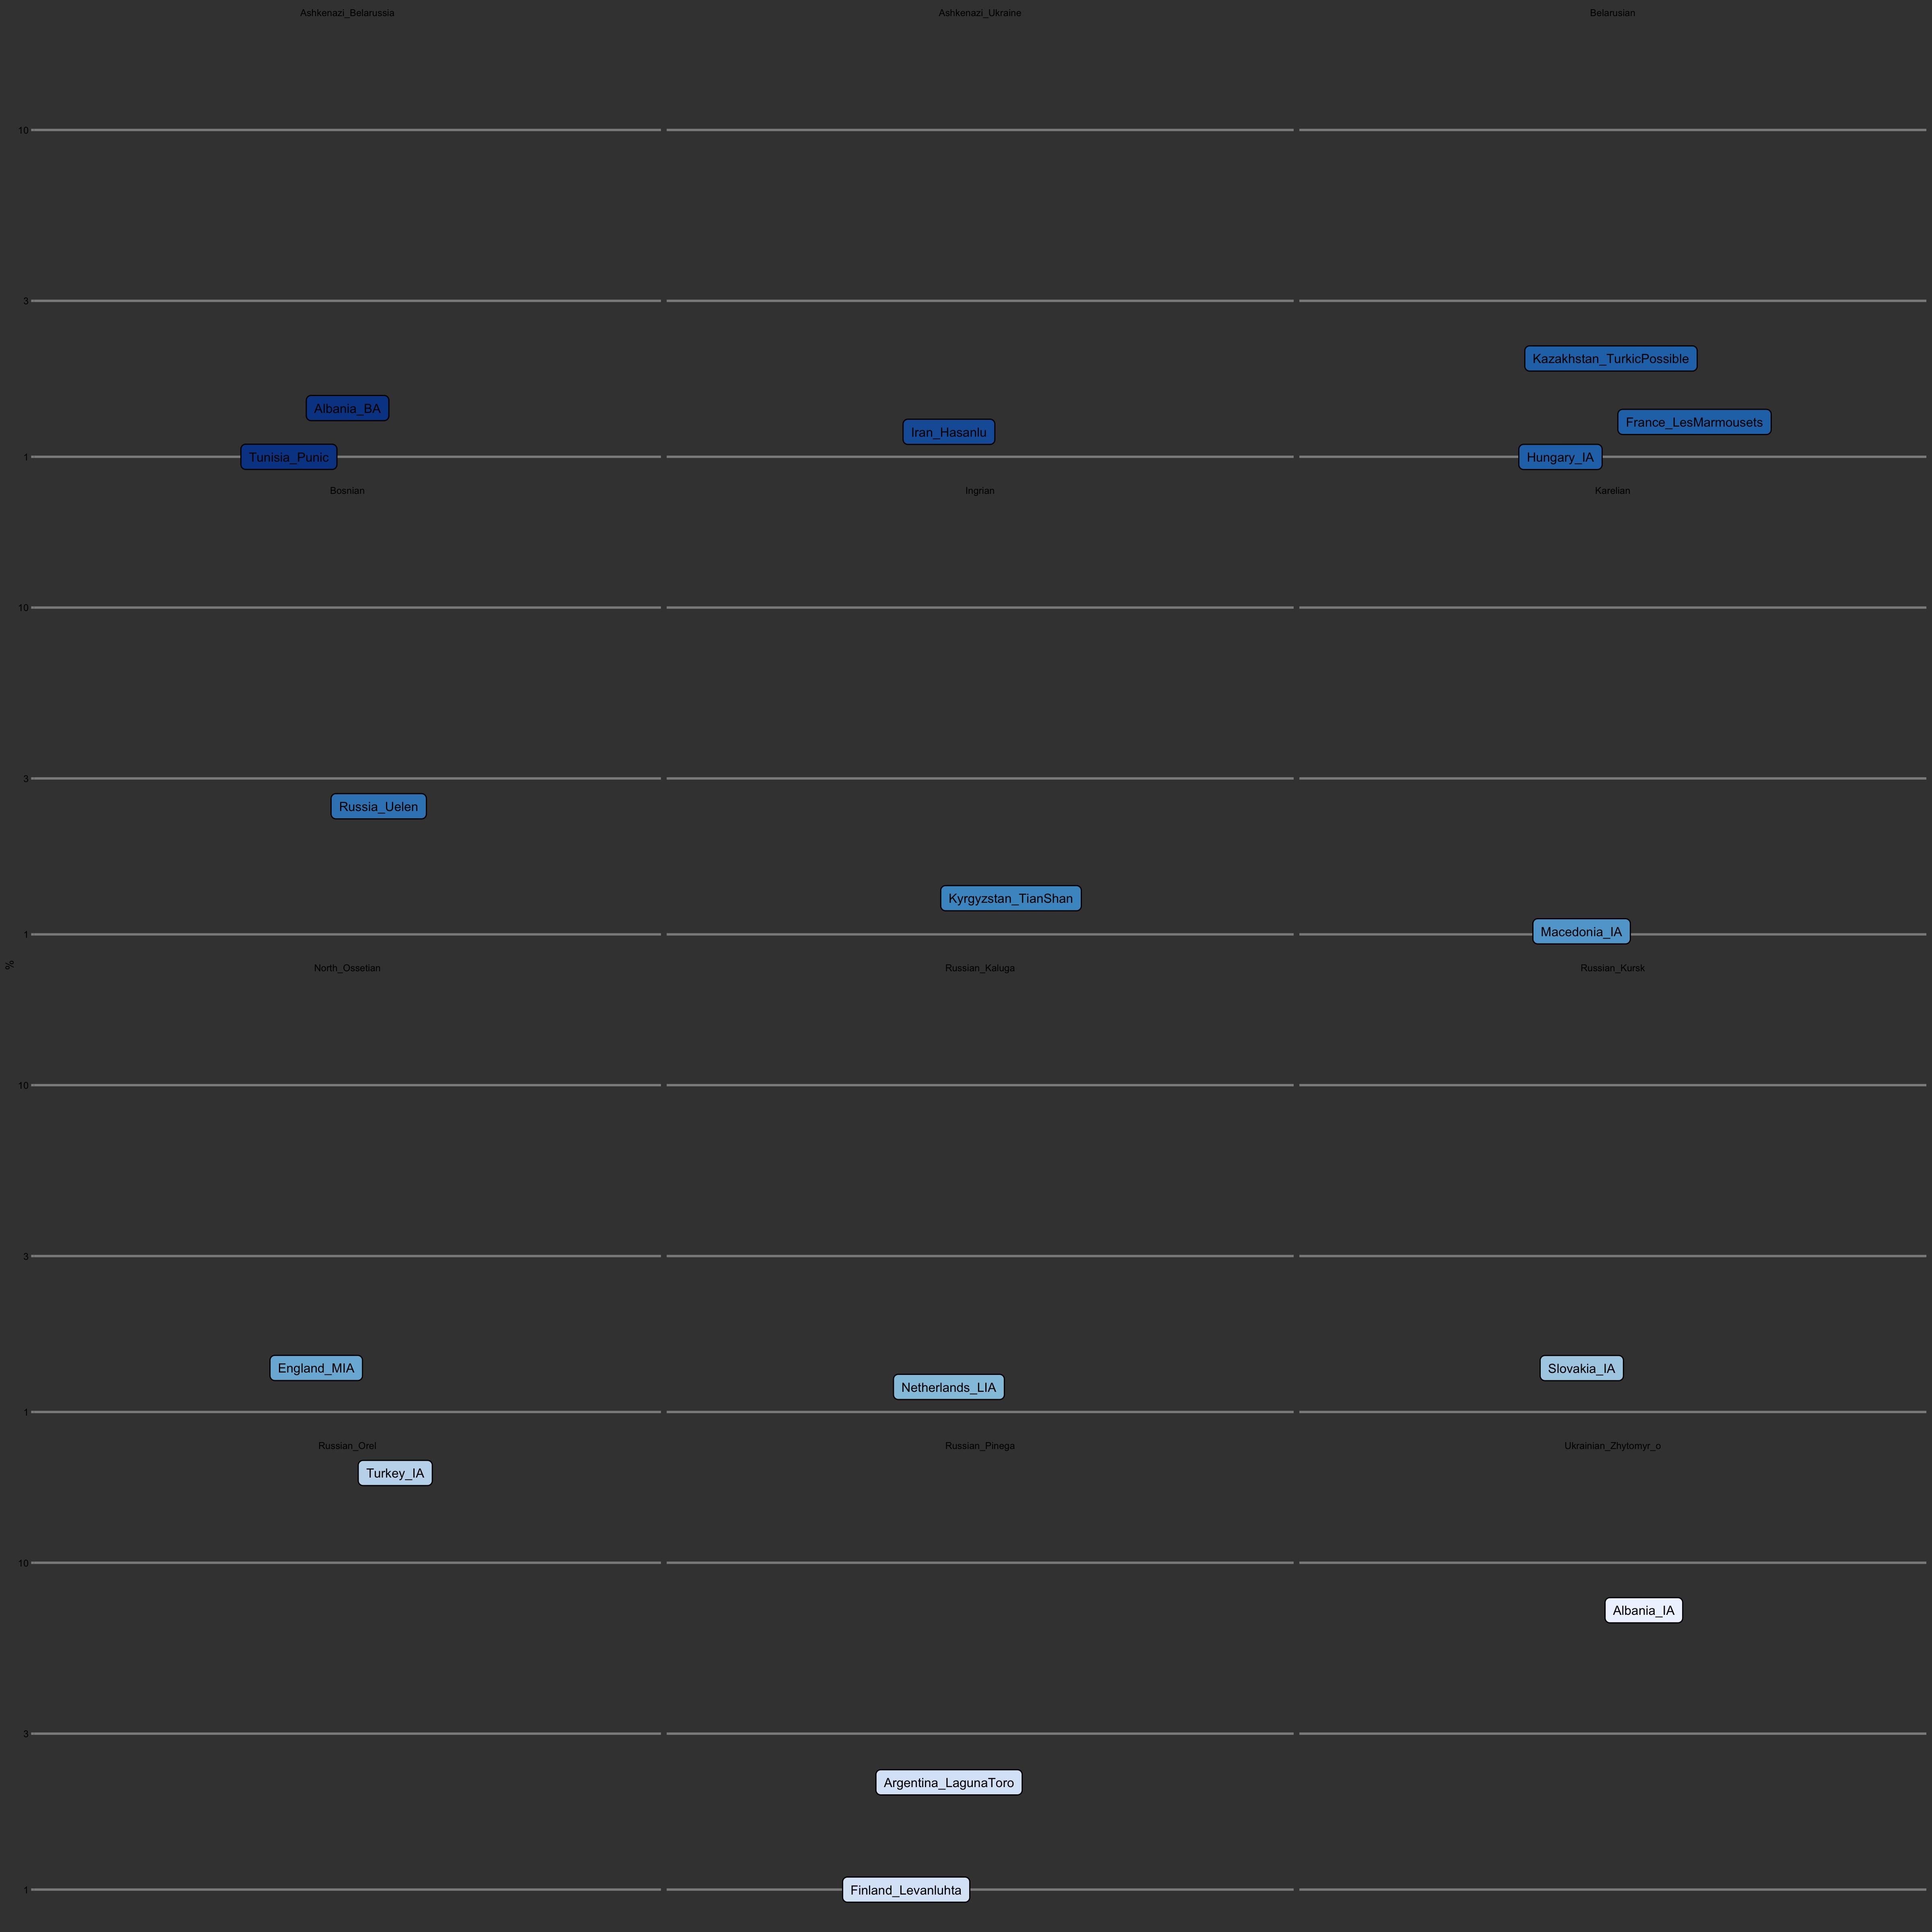

In [213]:
plotfun(mprd %>% sample_n(16),lsz = 2,nrw = 4)

Try extra metadata and retain

In [230]:
myd = as_tibble(import("../Raw Data/Archeological Samples/aDNA-Y-mt/all-ancient-dna.xlsx"))

Warning message:
“Expecting numeric in AA1070 / R1070C27: got '...'”
Warning message:
“Expecting numeric in AA1476 / R1476C27: got '...'”
Warning message:
“Expecting numeric in AA1477 / R1477C27: got '...'”
Warning message:
“Expecting numeric in AO2887 / R2887C41: got '..'”
Warning message:
“Expecting numeric in AA4167 / R4167C27: got '...'”
Warning message:
“Expecting numeric in AO5085 / R5085C41: got '..'”
Warning message:
“Coercing text to numeric in AO7537 / R7537C41: '0.088'”
Warning message:
“Expecting numeric in AO8135 / R8135C41: got '..'”
Warning message:
“Expecting numeric in AO8222 / R8222C41: got '..'”
Warning message:
“Expecting numeric in AO8246 / R8246C41: got '..'”
Warning message:
“Expecting numeric in AO11704 / R11704C41: got '..'”
Warning message:
“Expecting numeric in AO11886 / R11886C41: got '..'”
Warning message:
“Coercing text to numeric in AO14505 / R14505C41: '0.778'”


In [369]:
bad = as_tibble(import("../Genetics/G25/Data/CSV/Eurasia/G25_BA.csv"))
iad = as_tibble(import("../Genetics/G25/Data/CSV/Eurasia/G25_IA.csv"))
mad = as_tibble(import("../Genetics/G25/Data/CSV/Eurasia/G25_MA.csv"))

In [333]:
myd %>% sample_n(5)

Object-ID Colloquial-Skeletal                                        
1 VK554     Estonia_Salme_II-L                                         
2 STR355c   STR_355                                                    
3 BOO49-1   NA                                                         
4 Val107    Val 2009/Niv.3/S17 n107/ Mat: Diente/ z inf:143/Data: 08/07
5 WEHR_1414 WEHR_1414                                                  
  Latitude Longitude Sex mtDNA-coverage mtFAR     mtDNA-haplogroup
1 58.17000 22.25000  M   71.5           0.1659259 W6a             
2 48.89000 12.57000  F   ..             0.3917808 H60a            
3 69.06180 36.38113  NA  NA             0.1962457 U5a             
4 42.85710 -7.23146  U   NA             0.9534247 H1bm            
5 48.25283 10.80879  U   ..             1.0000000 K1a1b1g         
  mtDNA-Haplotree
1 W6a            
2 H60a           
3 U5a            
4 H1bm           
5 K1a1b1g        
  mt-FTDNA                                                             ⋯
1 https://www.familytreedna.com/public/mt-dna-haplotree/W;name=W6a     ⋯
2 https://www.familytreedna.com/public/mt-dna-haplotree/H;name=H60a    ⋯
3 https://www.familytreedna.com/public/mt-dna-haplotree/U;name=U5a     ⋯
4 https://www.familytreedna.com/public/mt-dna-haplotree/H;name=H1bm    ⋯
5 https://www.familytreedna.com/public/mt-dna-haplotree/K;name=K1a1b1g ⋯
  Location                    SiteID Country LP Skin                 Hair Eye
1 Saaremaa                    Salme  Estonia NA NA                   NA   NA 
2 Straubing- Bajuwarenstraße  355    Germany 1  Pale to Intermediate NA   NA 
3 Bol’shoy Oleni Ostrov       NA     Russia  NA NA                   NA   NA 
4 Valdavara 2, Becerrea, Lugo NA     Spain   NA NA                   NA   NA 
5 Wehringen – Hochfeld        WEHR   Germany NA NA                   NA   NA 
  P1104A Other Index
1 NA     NA    11592
2 NA     NA     7461
3 NA     NA     2036
4 NA     NA     7967
5 NA     NA     8469

Only keep the sample IDs for G25 coordinates

In [370]:
myptrna = "(?<=:).+$"
myptrnb = "^\\w+?_\\w+?(?=[_:\\.])"
bad = bad %>% mutate(label = str_extract(sample,myptrnb),sample = str_extract(sample,myptrna),.before = V2)
iad = iad %>% mutate(label = str_extract(sample,myptrnb),sample = str_extract(sample,myptrna),.before = V2)
mad = mad %>% mutate(label = str_extract(sample,myptrnb),sample = str_extract(sample,myptrna),.before = V2)

In [335]:
mad %>% sample_n(5)

sample   label               V2       V3       V4        V5        V6      
1 VK53     Sweden_Viking       0.118376 0.127957  0.071653  0.056848 0.048624
2 R1283.SG Italy_Medieval      0.110408 0.151314 -0.000377 -0.034884 0.029544
3 VK507    Estonia_EarlyViking 0.133173 0.132019  0.070522  0.063631 0.048932
4 R3918.SG Serbia_Sirmium      0.141141 0.143190  0.059585  0.028101 0.038776
5 VK284    Denmark_Viking      0.133173 0.135065  0.076933  0.066215 0.040623
  V7        V8       V9       ⋯ V17       V18       V19       V20     
1  0.020638 0.005640 0.013153 ⋯ -0.009149 -0.008084  0.004434 0.011187
2 -0.008088 0.001880 0.003231 ⋯  0.002387  0.004824 -0.005701 0.002514
3  0.022311 0.007990 0.008307 ⋯  0.000265 -0.016168  0.003801 0.007793
4  0.013945 0.000470 0.014538 ⋯ -0.005967 -0.012647  0.002154 0.006411
5  0.025379 0.007755 0.003231 ⋯  0.014983  0.005867  0.001900 0.001508
  V21       V22       V23       V24       V25       V26      
1 -0.002376 -0.003119 -0.003710  0.004930 -0.005543 -0.001557
2 -0.002251  0.002246  0.004699 -0.002588 -0.000964 -0.000479
3  0.008504  0.010232 -0.003091  0.002465  0.013134 -0.001078
4 -0.002751  0.003119  0.005317  0.002835 -0.000723  0.002515
5  0.002376  0.009234  0.000495 -0.007765  0.019641  0.004311

In [371]:
mydd = mad %>% left_join(myd,by = c("sample" = "Object-ID"))

In [337]:
mydd %>% sample_n(5) %>% select(sample,label,Simplified_Culture,Culture_Grouping,Label,Location,Country,Mean)

sample label              Simplified_Culture Culture_Grouping
1 hav001 Gotland_VA         NA                 NA              
2 TAQ003 Italy_Lazio        NA                 NA              
3 UGU011 Mongolia_Selenge   Xiongnu            Late Xiongnu    
4 BUR002 Mongolia_Arkhangai Xiongnu            Late Xiongnu    
5 GOR001 Vladimir_MA        NA                 NA              
  Label                 Location                                         
1 NA                    NA                                               
2 NA                    NA                                               
3 Mongolia_Late Xiongnu Uguumur Uul, Selenge                             
4 Mongolia_Late Xiongnu Tamiryn Ulaan Khoshuu (Burkhan Tolgoi), Arkhangai
5 NA                    NA                                               
  Country  Mean
1 NA       NA  
2 NA       NA  
3 Mongolia -5  
4 Mongolia -5  
5 NA       NA

In [240]:
mydd %>% count(Culture_Grouping,sort = TRUE)

Culture_Grouping           n  
1  NA                         414
2  Viking Sweden              118
3  Viking Denmark              68
4  Mongol                      49
5  Early_Viking                42
6  Viking UK                   28
7  Viking Norway               26
8  Viking Russia               26
9  Longobard Kingdom           20
10 Viking Iceland              16
11 Late Xiongnu                14
12 Medieval                    13
13 Early_Norse                 12
14 Uyghur                      11
15 Early Xiongnu               10
16 Anglo-Saxon Early Period     8
17 Anglo-Saxon Middle Period    8
18 Germany Medieval             7
19 Viking Poland                7
20 Lebanon Middle Ages          6
21 Türk                         6
22 North East Iberia Medieval   5
23 Fatyanovo Boshnevo           4
24 Guanche_mummy                4
25 Sardinia Medieval            4
26 Viking Ireland               4
27 Viking Orkney                4
28 Khitan                       3
29 Late_Norse                   3
30 Early Middle Ages            2
31 Muslim                       2
32 Viking Ukraine               2
33 "La Tène"                    1
34 Apulia Early Iron Age        1
35 Bavarian                     1
36 Bulgaria_EBA_EIA             1
37 Chilpek_800CE                1
38 Cis-Baikal Medieval          1
39 Heishui_Mohe_EarlyMedieval   1
40 High Middle Ages             1
41 Hungary Avar Late            1
42 Hungary Medieval             1
43 Kayalyk_950CE                1
44 Mongolia_LBA_Ulaanzukh       1
45 Old Bering Sea               1
46 Pict Orkney                  1
47 SE_Iberia_c.5-8CE            1
48 Saltovo-Mayaki               1
49 Sardinia_LateAntiquity       1
50 Slab Grave                   1
51 Turk                         1
52 Unclassified                 1
53 Ust'-Belaya medieval         1
54 Viking Faroes                1
55 Viking IsleOfMan             1
56 Viking Wales                 1

Optional time frame

In [283]:
mydd = mydd %>% dplyr::filter(Mean > 600,Mean < 1400)

Create class variable to label records by

In [372]:
mydd = mydd %>% 
        mutate(sample = ifelse(is.na(Location),label,paste(Culture_Grouping,Location,sep = "_"))) %>% 
        #mutate(sample = ifelse(is.na(Label),label,Label)) %>% #paste(Country,str_remove_all(Location,"[[:punct:]]"),sep = "_"))) %>% 
        mutate(sample = str_extract(sample,"^\\w{3,20}")) %>% 
        select(sample,all_of(matches("^V\\d")))

In [344]:
dim(mydd)
mydd %>% sample_n(5)

[1] 970  26

sample               V2       V3        V4       V5        V6       
1 England_EarlyMedieva 0.129758  0.136081 0.069767  0.064600  0.044624
2 Mongolia_Arkhangai   0.058050 -0.265053 0.042615 -0.009367 -0.030467
3 Longobard            0.121791  0.144205 0.036204  0.003876  0.041238
4 Viking               0.125205  0.128972 0.077687  0.070737  0.046470
5 Croatia_MLBA         0.126344  0.147252 0.026776  0.011951  0.031083
  V7        V8        V9        V10       ⋯ V17       V18      V19      
1  0.014223  0.007050  0.014769  0.003477 ⋯  0.016043 0.018906  0.003294
2 -0.003904  0.007990  0.008538 -0.019634 ⋯  0.003580 0.004172 -0.003294
3  0.005578 -0.005170 -0.000462  0.015953 ⋯ -0.007690 0.001043 -0.001520
4  0.024542  0.009870  0.009461 -0.000818 ⋯  0.010872 0.001825  0.005068
5  0.003626 -0.000235 -0.003000  0.012885 ⋯  0.002254 0.009648 -0.004687
  V20       V21       V22       V23       V24       V25       V26      
1 -0.001885  0.014132  0.004617  0.008285  0.002342  0.015062  0.001676
2  0.002765 -0.009880 -0.012852 -0.004575 -0.011462 -0.010001 -0.003113
3  0.004148 -0.004377  0.001872  0.005070 -0.001109 -0.004579  0.002395
4  0.004777  0.004627  0.006738  0.000618 -0.000986  0.010483  0.000599
5  0.013198 -0.001251  0.003369  0.001237 -0.002835  0.000602 -0.008742

In [373]:
mdl = myfun(na.omit(mydd),e = 1,a = 0,l = 15)

[1] "Number of classes: 161"
[1] "Split into test and train samples"
[1] 726  26
[1] 243  26
[1] "Starting XGBoost training"
[1]	train-mlogloss:4.050391	test-mlogloss:4.315009 
[26]	train-mlogloss:1.775341	test-mlogloss:3.138489 
[51]	train-mlogloss:1.246856	test-mlogloss:3.125116 
[76]	train-mlogloss:1.012101	test-mlogloss:3.156902 
[100]	train-mlogloss:0.889194	test-mlogloss:3.155126 
# A tibble: 15 × 5
     row label variable  value maxval
   <int> <dbl> <chr>     <dbl>  <dbl>
 1   127    51 157      0.654  0.654 
 2   191   159 160      0.191  0.191 
 3   219   159 159      0.507  0.507 
 4    21   159 159      0.907  0.907 
 5   121    47 159      0.890  0.890 
 6    56    24 159      0.621  0.621 
 7   143    17 17       0.237  0.237 
 8   192   159 38       0.369  0.369 
 9    47    24 159      0.401  0.401 
10   189   159 159      0.248  0.248 
11   117    43 11       0.226  0.226 
12    44     1 1        0.670  0.670 
13   144    99 160      0.0548 0.0548
14   100    42 140   

In [346]:
mprd = mypfun(mdl,na.omit(mydd),ppl)

[1] "Using 161 populations"


Joining with `by = join_by(variable)`


   name                  eth  value
1    MD                Early  5.19%
2    MD   Mongolia_Arkhangai  4.22%
3    MD       Czech_Medieval  2.93%
4    MN                Early  5.99%
5    MN               Apulia  4.91%
6    MN   Mongolia_Arkhangai  4.09%
7    MN           Sigtuna_VA  2.37%
8    MN Sardinia_LateAntiqui 19.95%
9    RN   Mongolia_Arkhangai  6.16%
10   RN                Early  4.85%
11   RN               Apulia  3.47%
12   RN         Stockholm_VA  2.12%
13   RN Sardinia_LateAntiqui  2.03%
14   TP         Uppland_Late  8.25%
15   TP          Jamtland_VA   2.4%
16   TP        Poland_Santok  2.34%
17   TP      Medieval_Kraków 15.69%


In [374]:
mprd = mypfun2(mdl,na.omit(mydd),ppl %>% dplyr::filter(!str_detect(V1,"TP")))

[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`


[1] "Using 161 populations"


Joining with `by = join_by(variable)`
`summarise()` has grouped output by 'name'. You can override using the
`.groups` argument.


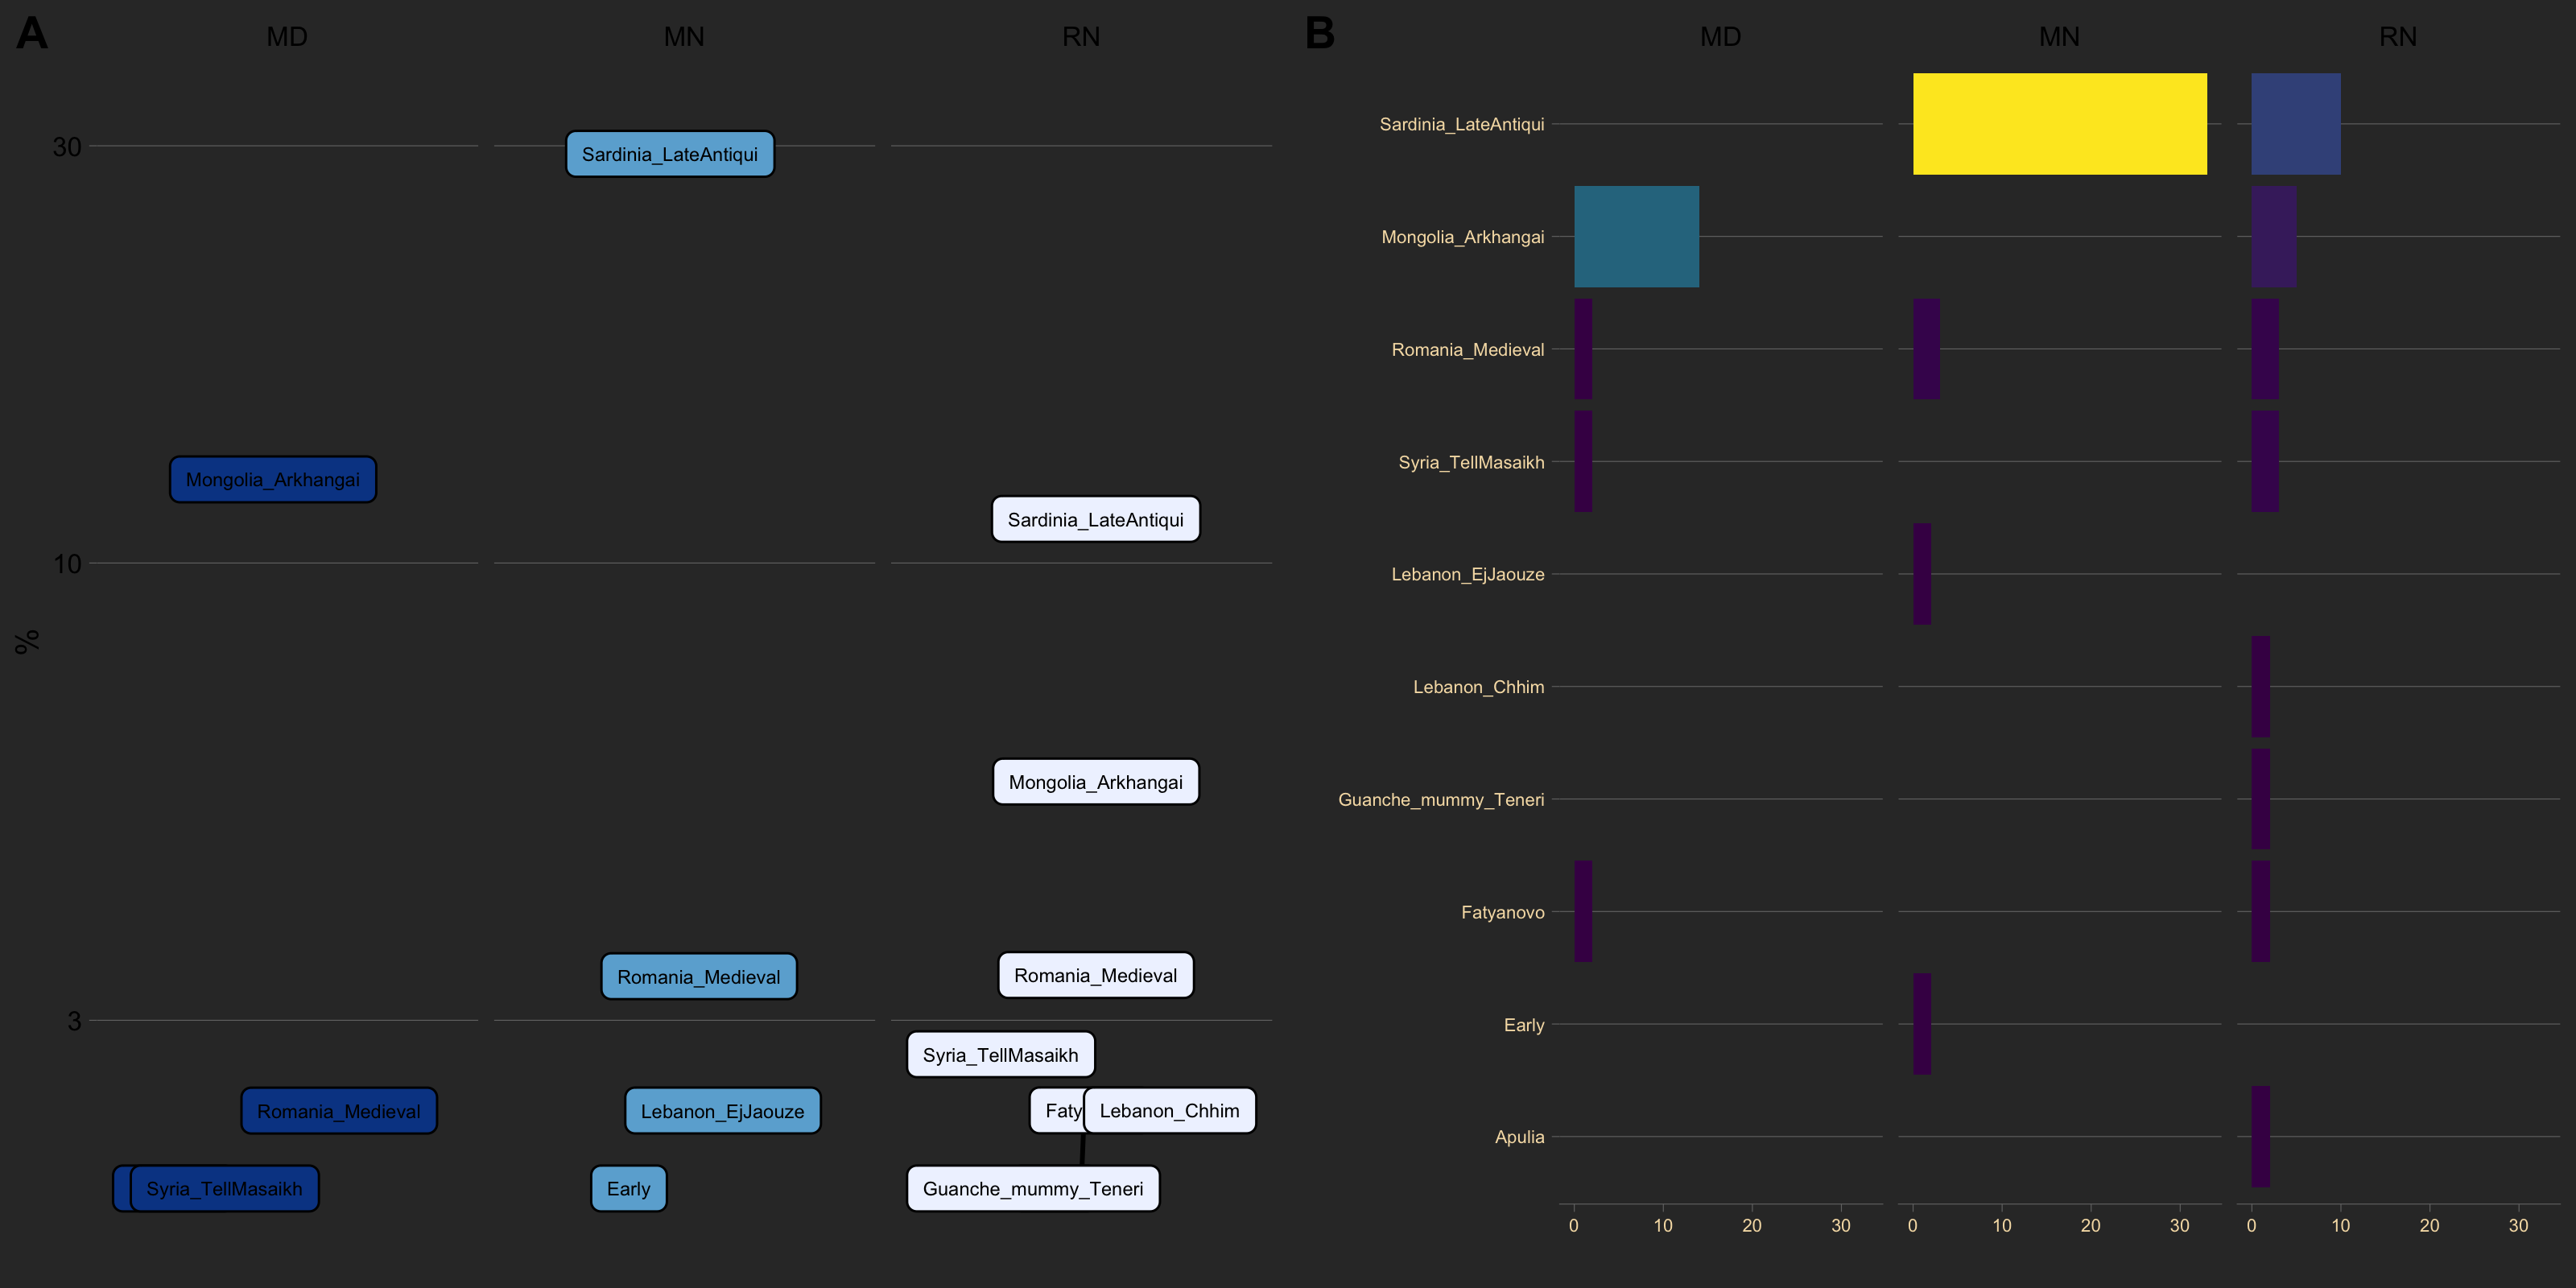

In [375]:
plotfun3(mprd)